# Health Insurance Cross Sell Prediction


https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

## Imports

In [38]:
import pandas as pd
import os
import inflection
import numpy as np
import pickle
from scipy.stats import randint

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scikitplot.metrics import plot_cumulative_gain

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

## Helper Function

In [19]:
def jupyter_settings():
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from IPython.display import display, HTML

    # Matplotlib and Seaborn configuration
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    sns.set()

    # Pandas display options
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)


jupyter_settings()

In [20]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def cramers_v_matrix(df_cat):
    cols = df_cat.columns
    matrix = pd.DataFrame(index=cols, columns=cols)
    for col1 in cols:
        for col2 in cols:
            matrix.loc[col1, col2] = cramers_v(df_cat[col1], df_cat[col2])
    return matrix.astype(float)

In [21]:
def valid_params(params):
    if params['penalty'] == 'elasticnet' and 'l1_ratio' not in params:
        return False
    if params['penalty'] in ['l1', 'l2'] and 'l1_ratio' in params:
        return False
    return True

In [22]:
def precision_at_k(y_true, y_proba, k=0.1):
    """
    Calcula a Precision@K.

    y_true: array-like (valores reais, binários)
    y_proba: array-like (probabilidade estimada da classe positiva)
    k: percentual da amostra (entre 0 e 1)

    Retorna: precisão no top K%
    """
    # Número de amostras no top K%
    cutoff = int(len(y_proba) * k)

    # Ordenar por probabilidade decrescente
    sorted_indices = np.argsort(y_proba)[::-1]
    top_k_indices = sorted_indices[:cutoff]

    # Calcular precisão no top K%
    precision = y_true.iloc[top_k_indices].sum() / cutoff
    return precision

In [23]:
def recall_at_k(y_true, y_proba, k=0.1):
    """
    Calcula a Recall@K.

    y_true: array-like ou pandas.Series (valores reais, binários)
    y_proba: array-like ou pandas.Series (probabilidades da classe positiva)
    k: percentual da amostra (entre 0 e 1)

    Retorna: recall no top K%
    """
    # Converter para Series se necessário
    y_true = pd.Series(y_true)
    y_proba = pd.Series(y_proba)

    # Número de amostras no top K%
    cutoff = int(len(y_proba) * k)

    # Ordenar por probabilidade decrescente
    sorted_indices = np.argsort(y_proba)[::-1]
    top_k_indices = sorted_indices[:cutoff]

    # Verdadeiros positivos no top K%
    true_positives_at_k = y_true.iloc[top_k_indices].sum()

    # Total de positivos no conjunto
    total_positives = y_true.sum()

    recall = true_positives_at_k / total_positives if total_positives > 0 else 0
    return recall



In [24]:
def cross_validation(model, X, y, k=0.5, n_splits=5, random_state=42, verbose=True):
    """
    Aplica validação cruzada com cálculo do recall@k em cada fold.

    Parâmetros:
    - model: classe do modelo
    - X, y: dados de entrada (X = features, y = target)
    - k: percentual do top K% (ex: 0.5 para top 50%)
    - n_splits: número de folds na CV
    - random_state: para reprodutibilidade
    - verbose: se True, imprime resultados finais

    Retorna:
    - Lista com o recall@k de cada fold
    - Média e desvio padrão do recall@k
    """
    recall_scores = []
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)

        y_proba = model.predict_proba(X_val)[:, 1]
        score = recall_at_k(y_val, y_proba, k=k)
        recall_scores.append(score)

    mean_recall = np.mean(recall_scores)
    std_recall = np.std(recall_scores)

    if verbose:
        print(f"Recall@{int(k*100)}% médio: {mean_recall:.4f}")
        print(f"Desvio padrão: {std_recall:.4f}")

    return recall_scores, mean_recall, std_recall

In [25]:
from imblearn.pipeline import Pipeline

def cross_val_precision_recall_at_k_pipeline(X, y, model, sampler, k=0.5, n_splits=5, random_state=42):
    precision_scores = []
    recall_scores = []

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipe = Pipeline([
            ('smote', sampler),
            ('model', model)
        ])

        pipe.fit(X_tr, y_tr)
        y_proba = pipe.predict_proba(X_val)[:, 1]

        # Garantir que y_val e y_proba sejam Series
        y_val = pd.Series(y_val).reset_index(drop=True)
        y_proba = pd.Series(y_proba).reset_index(drop=True)

        cutoff = int(len(y_proba) * k)
        sorted_idx = np.argsort(y_proba)[::-1]
        top_k = sorted_idx[:cutoff]

        tp = y_val.iloc[top_k].sum()
        precision_k = tp / cutoff
        recall_k = tp / y_val.sum()

        precision_scores.append(precision_k)
        recall_scores.append(recall_k)

    mean_precision = np.mean(precision_scores)
    std_precision = np.std(precision_scores)

    mean_recall = np.mean(recall_scores)
    std_recall = np.std(recall_scores)

    print(f"Recall@{int(k*100)}% médio com CV: {mean_recall:.4f} ± {std_recall:.4f}")
    print(f"Precision@{int(k*100)}% médio com CV: {mean_precision:.4f} ± {std_precision:.4f}")

    return precision_scores, recall_scores, mean_precision, mean_recall


## Upload Dataset

In [32]:
ROOT_PATH = os.getcwd()  # está em notebook/
train_path = os.path.join(ROOT_PATH, '..', 'datasets', 'train.csv')


df = pd.read_csv(train_path)

In [33]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Data Description

In [39]:
df1 = df.copy()

In [40]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map ( snakecase, cols_old ))

df1.columns = cols_new

df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

#### Data Types and Data Dimension

In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


#### Check NA

In [37]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

#### Data Descriptive

In [ ]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [ ]:
num_attributes.sample(10)

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
230551,230552,34,1,46.0,0,34129.0,124.0,11,0
100583,100584,47,1,33.0,0,34095.0,124.0,74,0
351838,351839,49,1,28.0,1,33925.0,26.0,277,0
51095,51096,25,1,12.0,1,24230.0,152.0,246,0
70878,70879,50,1,28.0,0,52549.0,124.0,278,0
233870,233871,56,1,28.0,1,42803.0,124.0,63,0
356650,356651,49,1,15.0,0,33977.0,124.0,144,1
309222,309223,21,1,13.0,0,31742.0,160.0,273,0
95643,95644,40,1,7.0,1,2630.0,26.0,239,0
268777,268778,23,1,2.0,1,24633.0,152.0,211,0


In [ ]:
cat_attributes.sample(10)

,gender,vehicle_age,vehicle_damage
373466,Male,1-2 Year,No
321070,Male,1-2 Year,Yes
85064,Male,1-2 Year,No
167168,Male,< 1 Year,No
290913,Female,< 1 Year,No
178392,Male,1-2 Year,Yes
153010,Female,1-2 Year,Yes
282232,Male,< 1 Year,No
266343,Female,< 1 Year,No
277887,Female,1-2 Year,No


In [ ]:
num_attributes.describe()

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [ ]:
cat_attributes.describe(include='object')

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


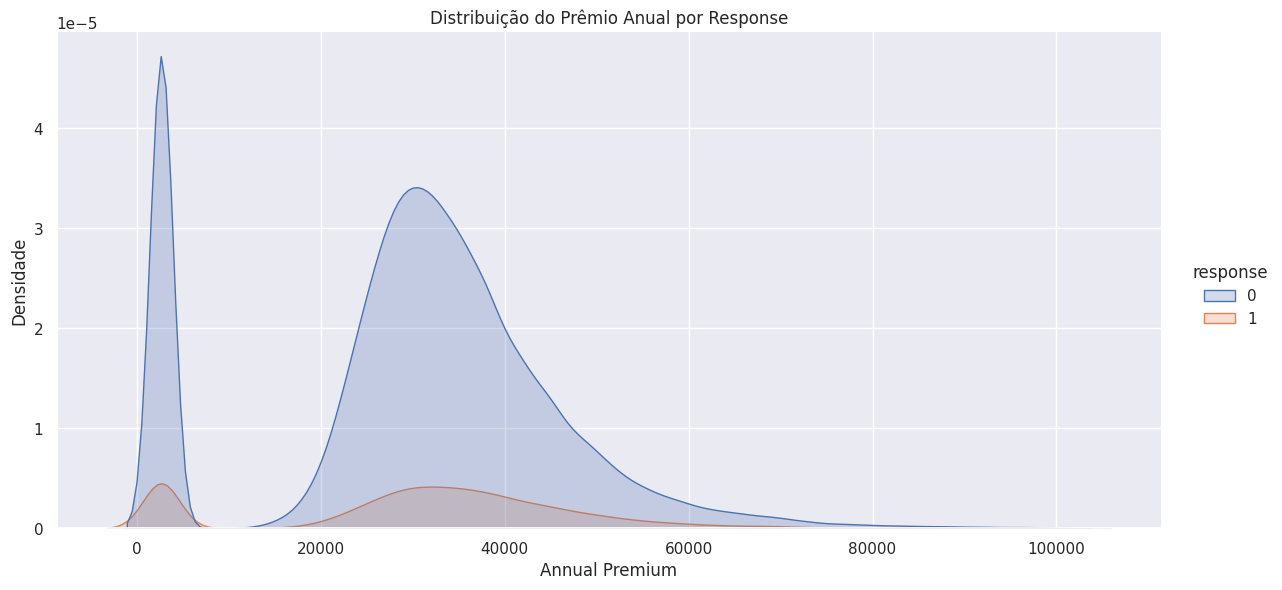

In [ ]:
#sns.displot(df1['annual_premium'])
sns.displot(
    data=df1[df1['annual_premium'] < 100000],
    x='annual_premium',
    hue='response',
    kind='kde',  # ou 'hist' se preferir histograma
    fill=True,
    height=6,
    aspect=2
)
plt.title('Distribuição do Prêmio Anual por Response')
plt.xlabel('Annual Premium')
plt.ylabel('Densidade')
plt.show()

In [ ]:
#sns.displot(df1['driving_license'])

print(df1['driving_license'].value_counts())

print(df1['previously_insured'].value_counts())

driving_license
1    380297
0       812
Name: count, dtype: int64
previously_insured
0    206481
1    174628
Name: count, dtype: int64


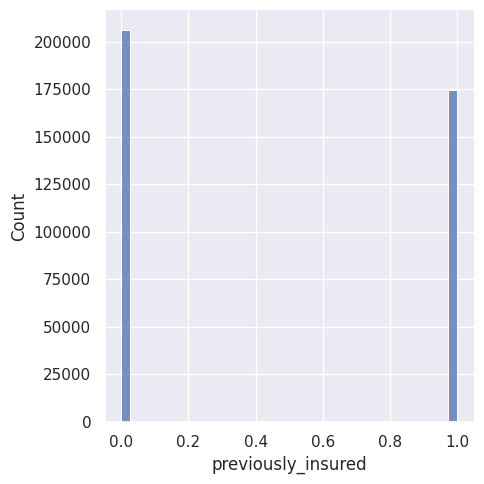

In [ ]:
sns.displot(df1['previously_insured'])

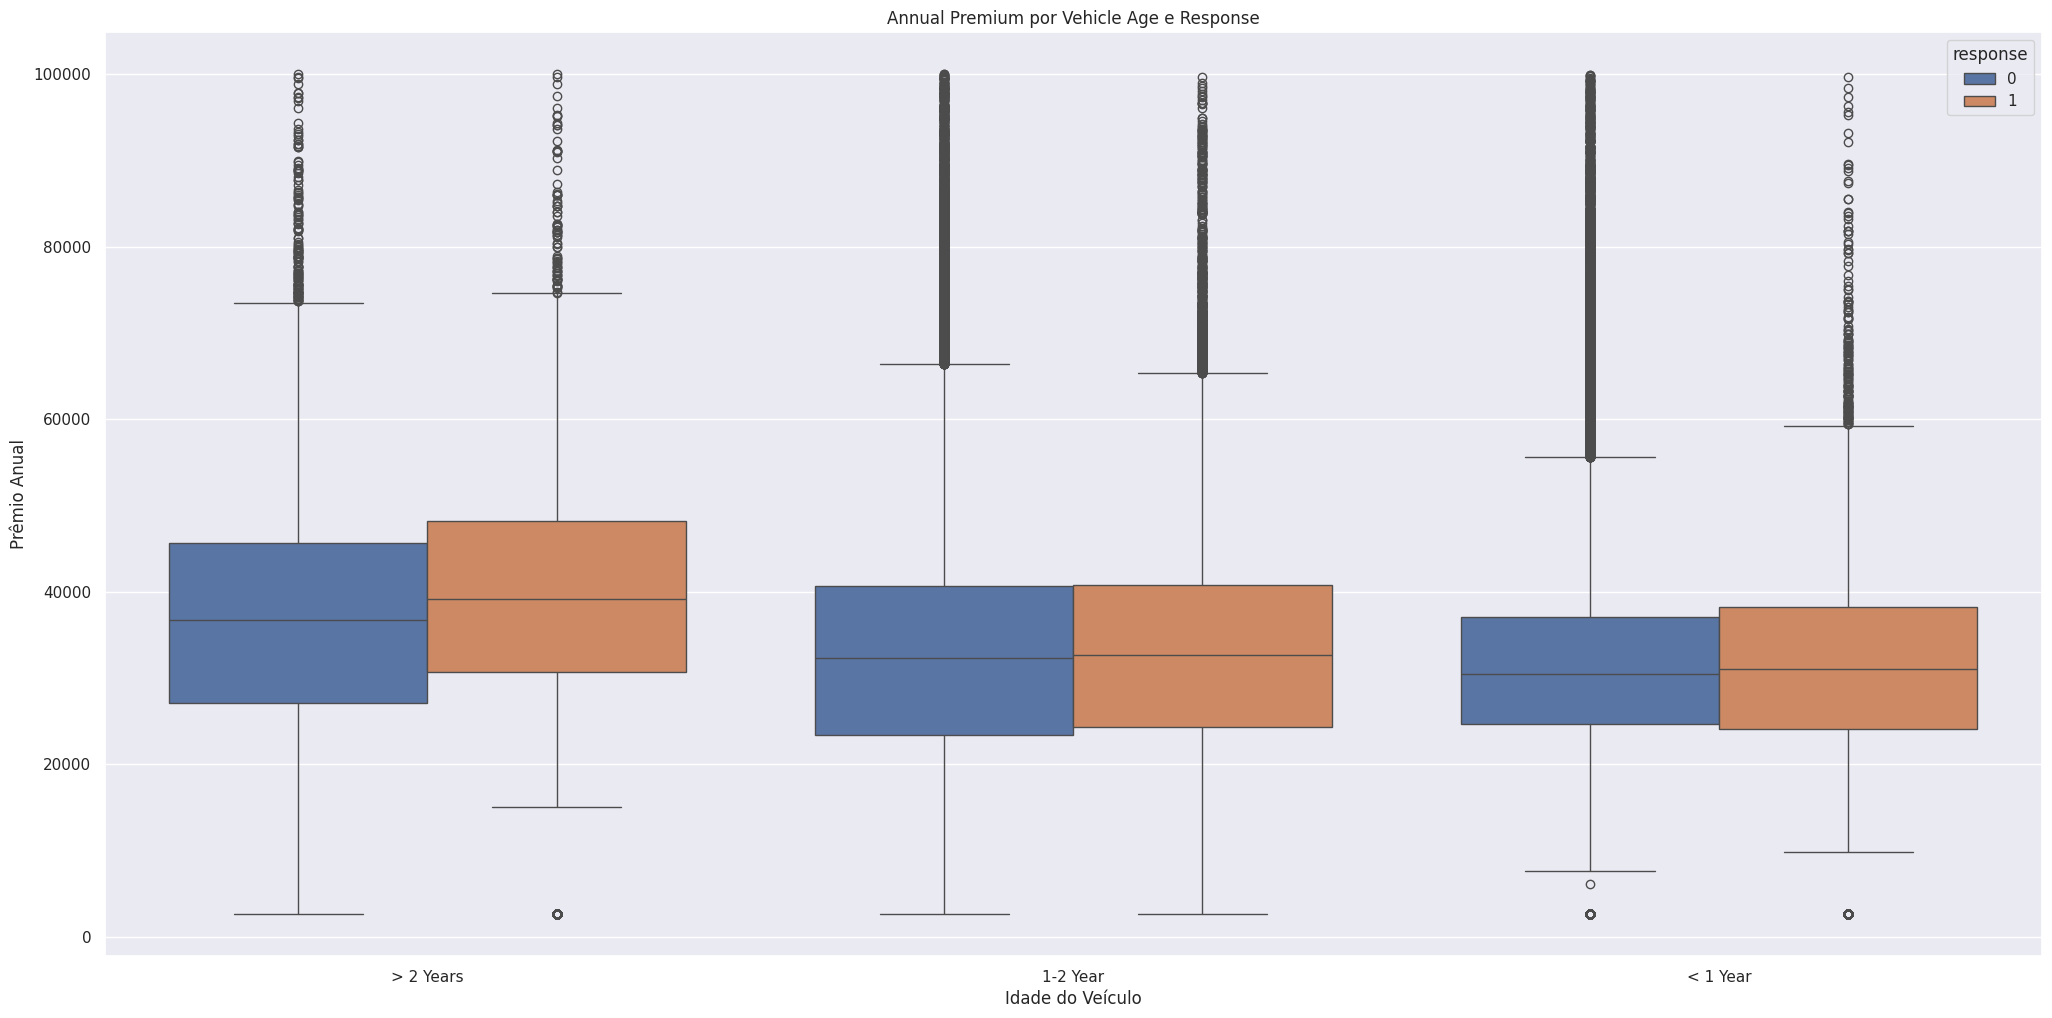

In [ ]:
aux1 = df1[df1['annual_premium'] < 100000]

sns.boxplot(x='vehicle_age', y='annual_premium', hue='response', data=aux1)
plt.title("Annual Premium por Vehicle Age e Response")
plt.xlabel("Idade do Veículo")
plt.ylabel("Prêmio Anual")
plt.show()


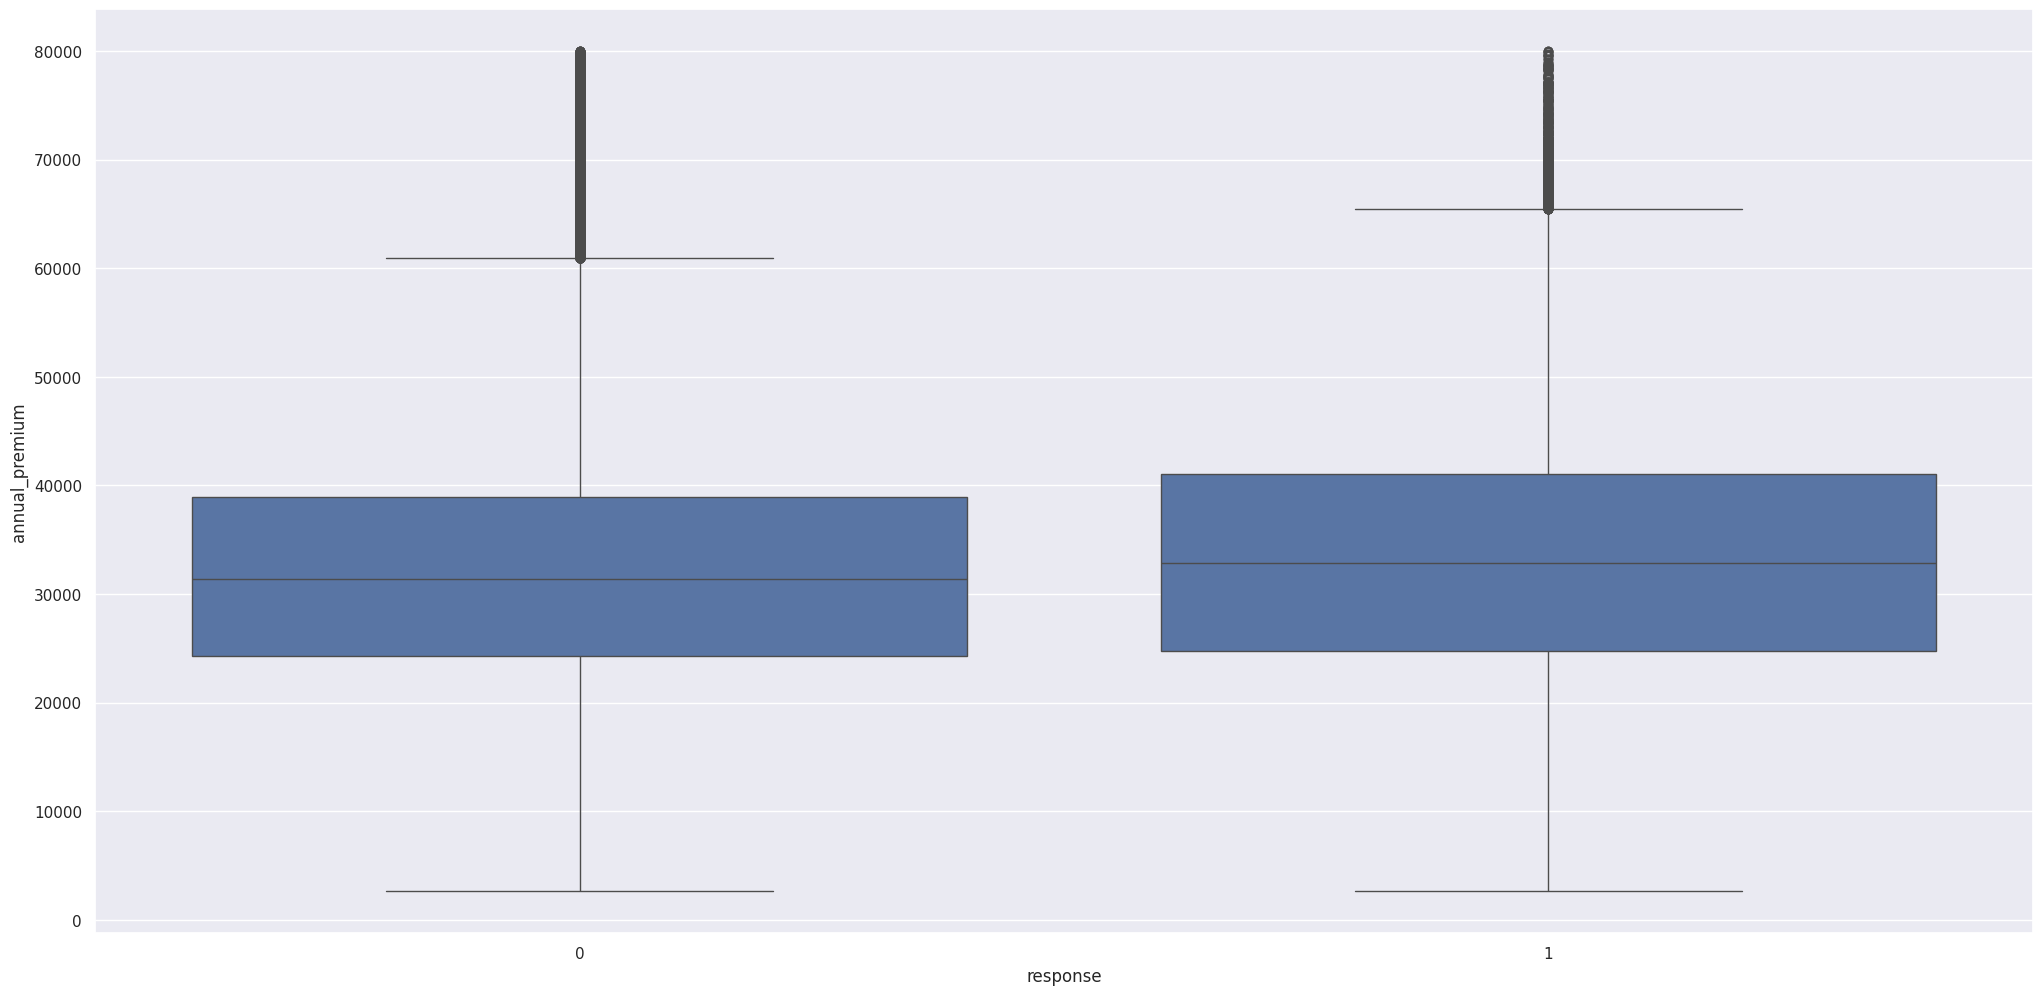

In [ ]:
aux1 = df1[df1['annual_premium'] < 80000]

sns.boxplot(x='response', y='annual_premium', data=aux1)
plt.show()

## Filtering Engineering

In [41]:
df2 = df1.copy()

In [42]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [43]:
def description_age(value):
  if value == '> 2 Years':
    return 'over_2_years'
  elif value == '1-2 Year':
    return 'between_1_2_year'
  else:
    return 'below_1_year'
  return


df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: description_age(x))


df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x =='Yes' else 0)

In [ ]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


## Data Filtering

In [44]:
df3 = df2.copy()

## EDA

Hipóteses levantadas:

H1. Donos de Carros comprados recentemente pode aceitar seguros mais facilmente. FALSO

H2. Mulheres tendem a aceitar seguros de carro mais facilmente, se comparados a homens. FALSO

H3. Clientes que sofreram dano em seu veículo têm maior chance de aceitar a proposta de seguro. VERDADE

H4. Clientes que ainda não possuem seguro têm maior taxa de conversão. VERDADE

H5. Clientes com maior tempo de relacionamento  têm maior propensão a aceitar o seguro. FALSA

H6. A faixa etária influencia na aceitação do seguro — especialmente entre jovens e idosos. VERDADE

H7. O valor do prêmio anual influencia negativamente a adesão ao seguro. FALSA

In [45]:
df4 = df3.copy()

In [46]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


#### Univariate Analysis

In [ ]:
#interessado - 1
#não interessado - 0

df4['response'].value_counts()

,count
response,
0,334399
1,46710


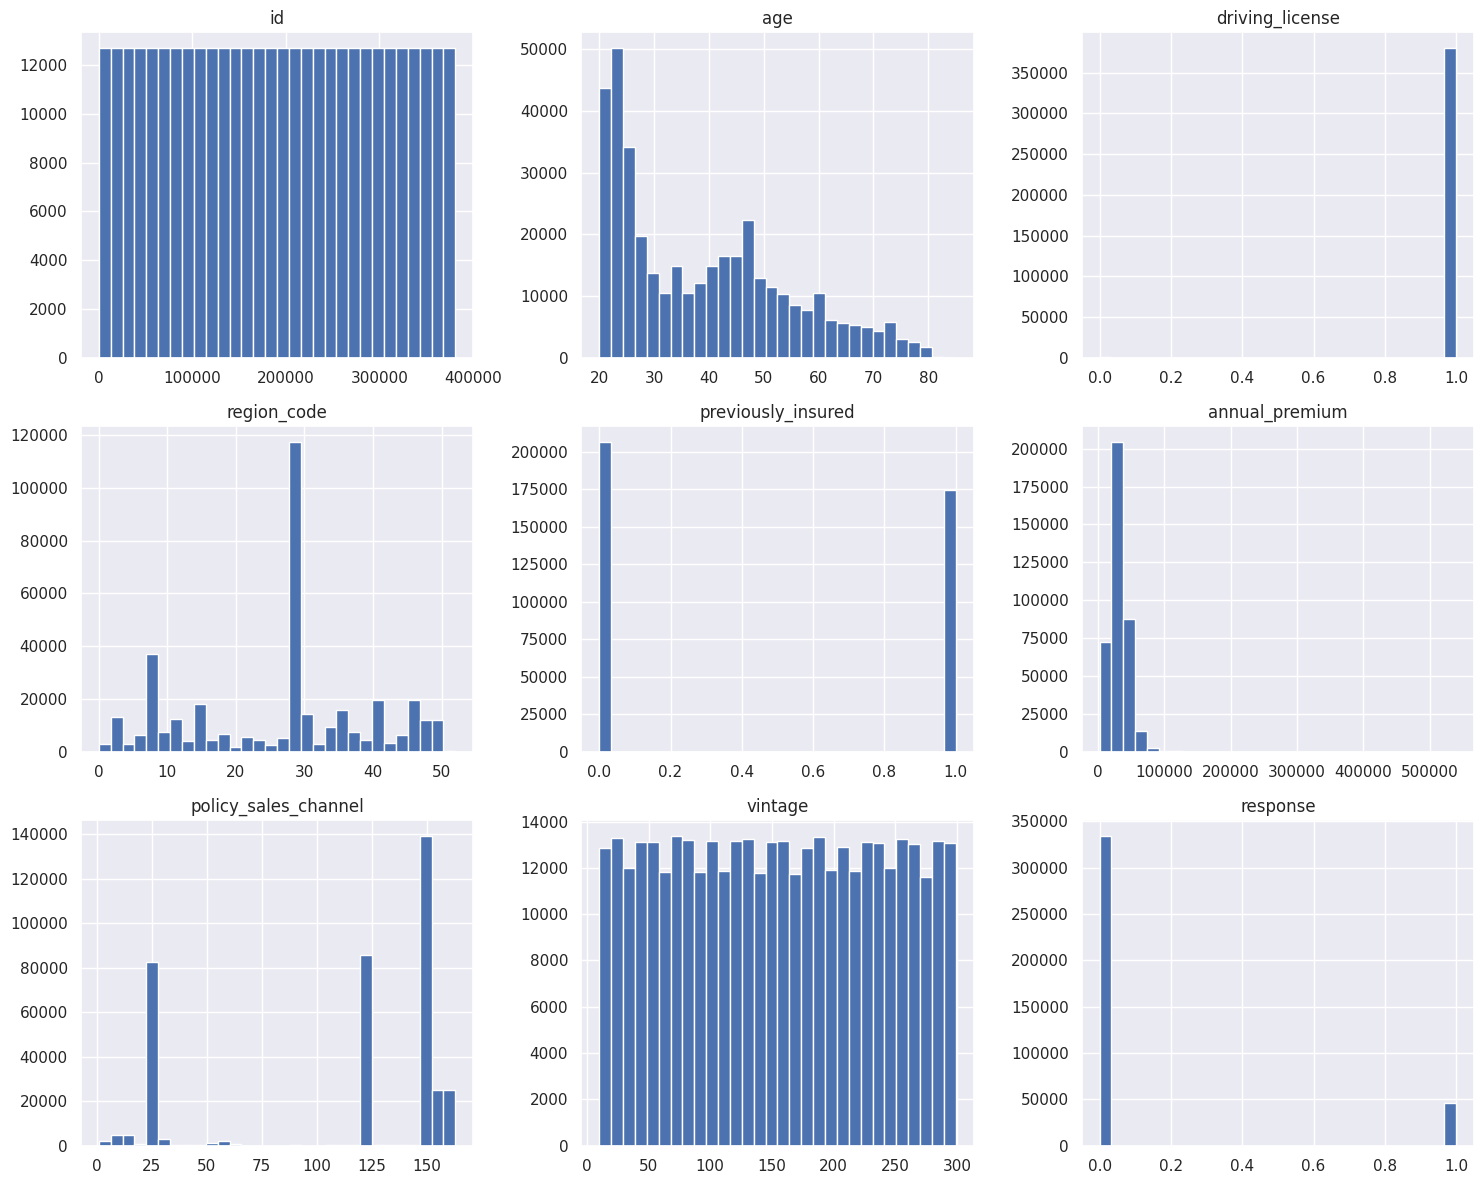

In [ ]:
num_attributes.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

<Axes: xlabel='response', ylabel='age'>

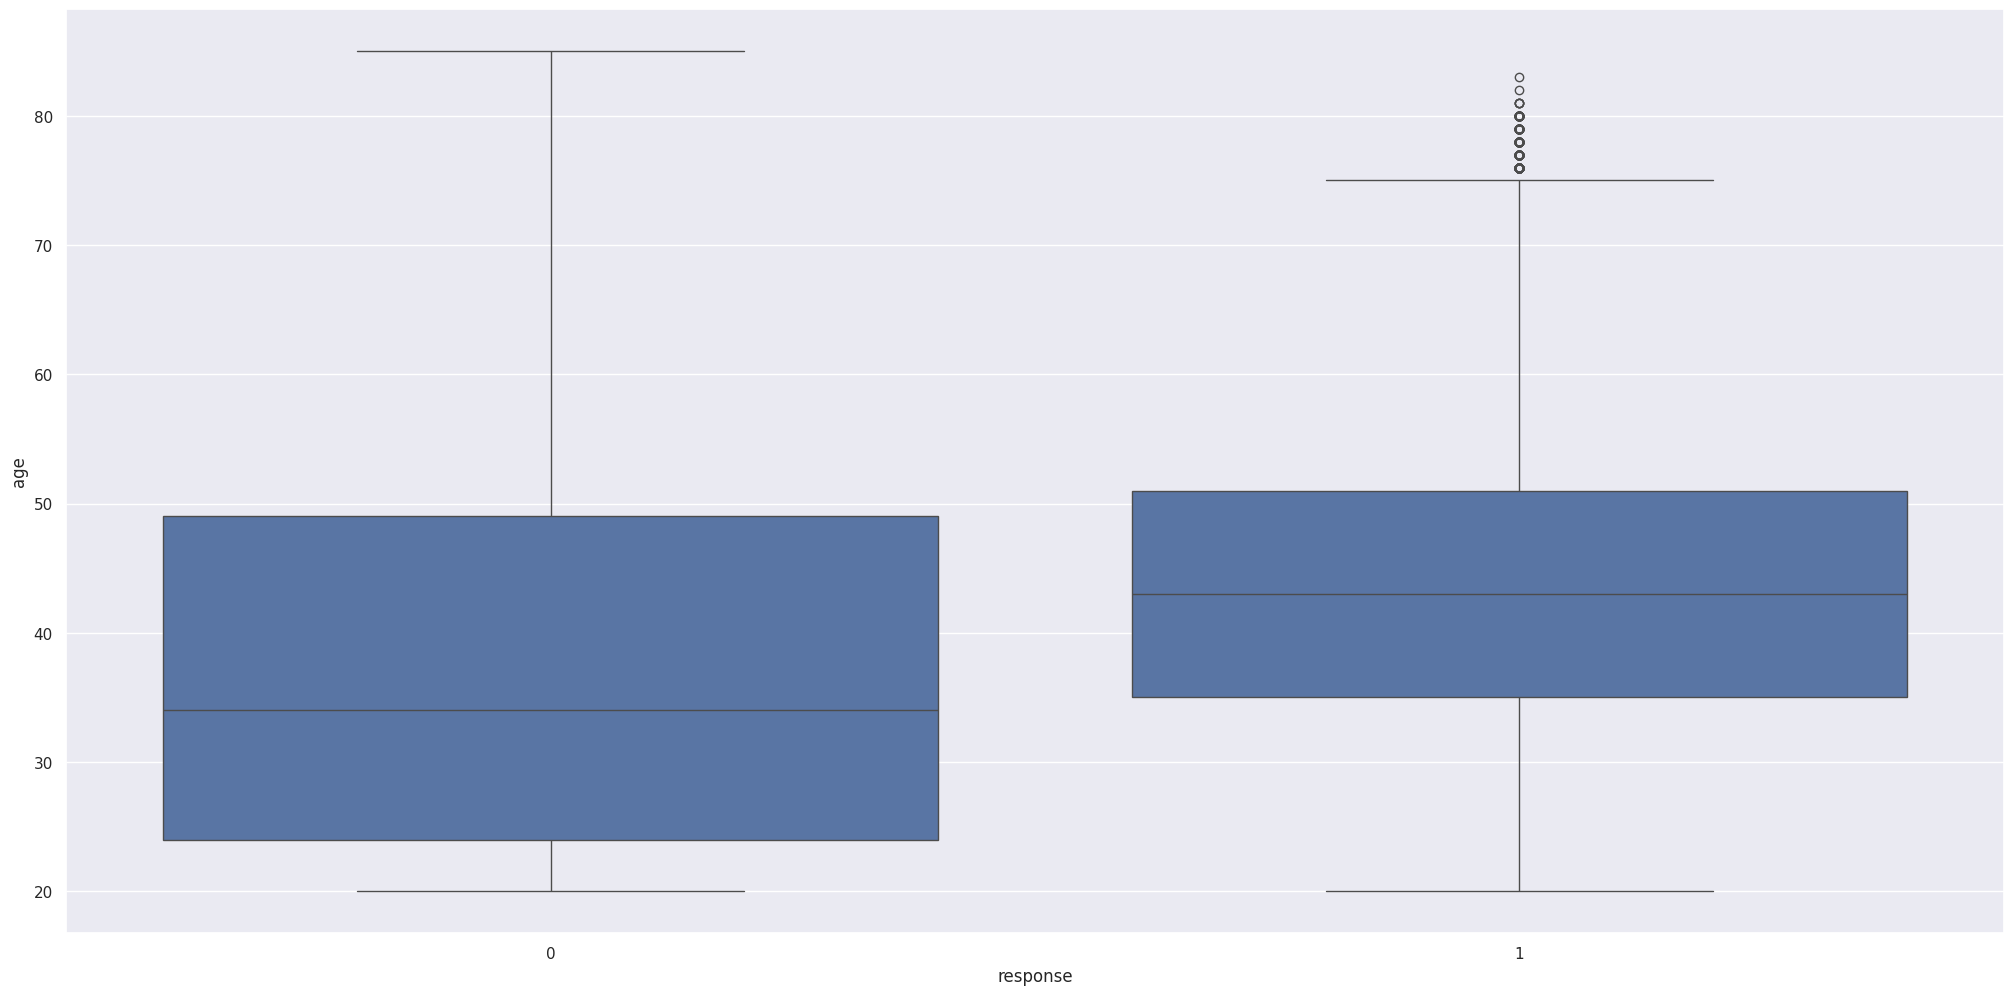

In [ ]:
sns.boxplot(x='response', y='age', data=df4)

H6. A faixa etária influencia na aceitação do seguro — especialmente entre jovens e idosos. (VERDADEIRA)

<Axes: xlabel='age', ylabel='Count'>

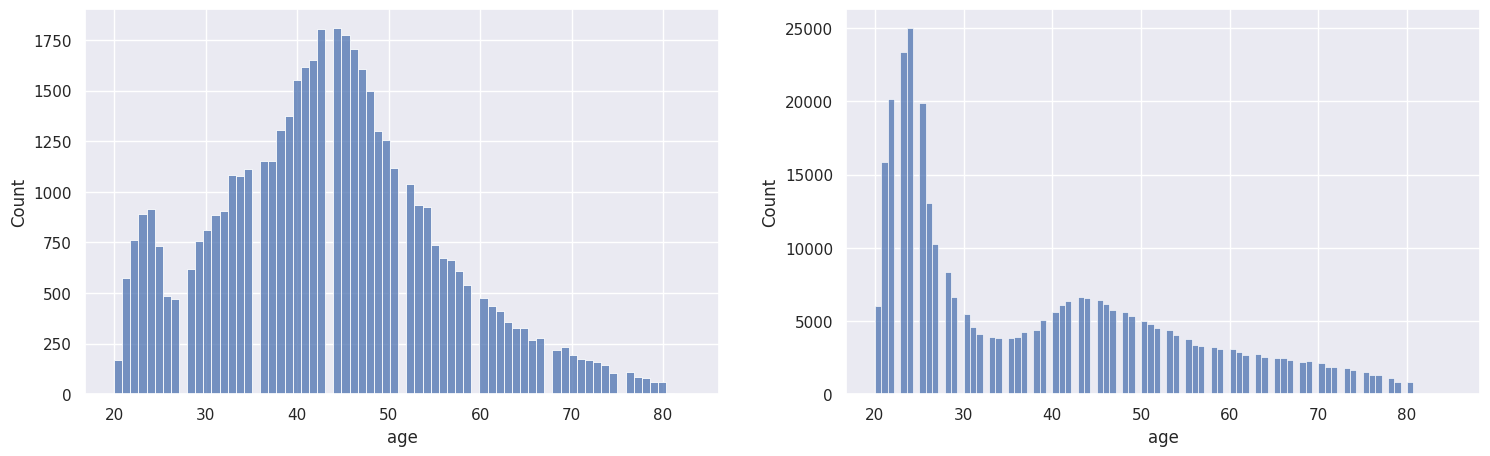

In [ ]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)

aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux)

plt.subplot(1, 2, 2)
aux = df4.loc[df4['response'] == 0, 'age']

sns.histplot(aux)

H7. O valor do prêmio anual influencia negativamente a adesão ao seguro. FALSA

<Axes: xlabel='annual_premium', ylabel='Count'>

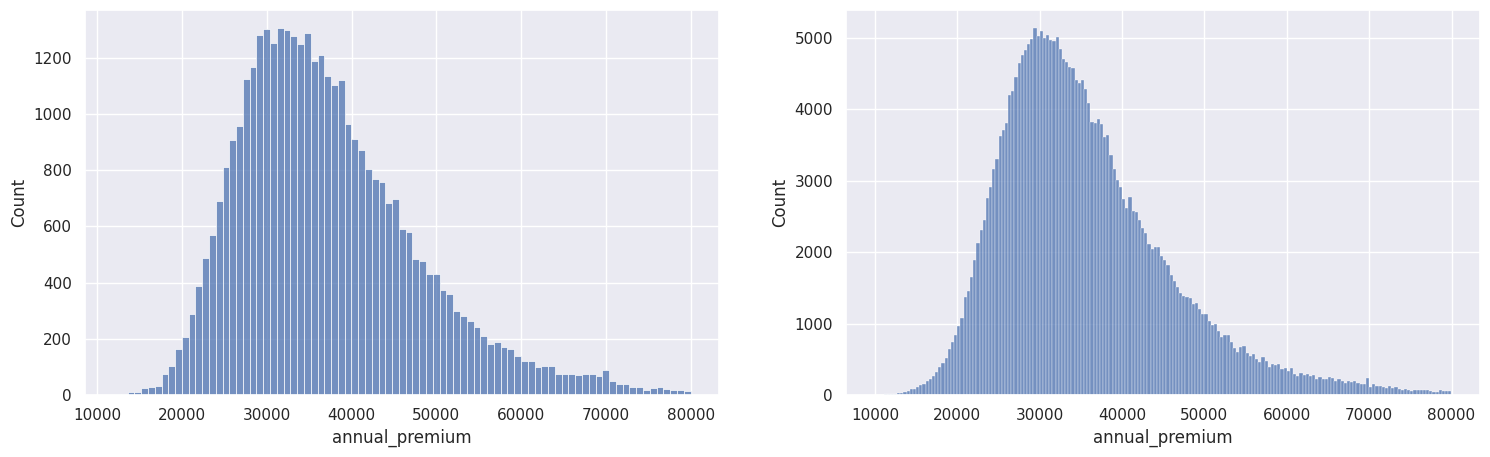

In [ ]:
aux01 = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)

aux = aux01 .loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux)

plt.subplot(1, 2, 2)
aux = aux01 .loc[df4['response'] == 0, 'annual_premium']

sns.histplot(aux)

In [ ]:
df4['premium_bin'] = pd.cut(df4['annual_premium'], bins=[0, 20000, 30000, 40000, 50000, 80000],
                            labels=['até 20k', '20-30k', '30-40k', '40-50k', '50k+'])
conversion_rate = df4.groupby('premium_bin')['response'].mean()

conversion_rate

/tmp/ipython-input-1118056972.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rate = df4.groupby('premium_bin')['response'].mean()


,response
premium_bin,
até 20k,0.126788
20-30k,0.100375
30-40k,0.119912
40-50k,0.143290
50k+,0.151915


<Axes: xlabel='response', ylabel='driving_license'>

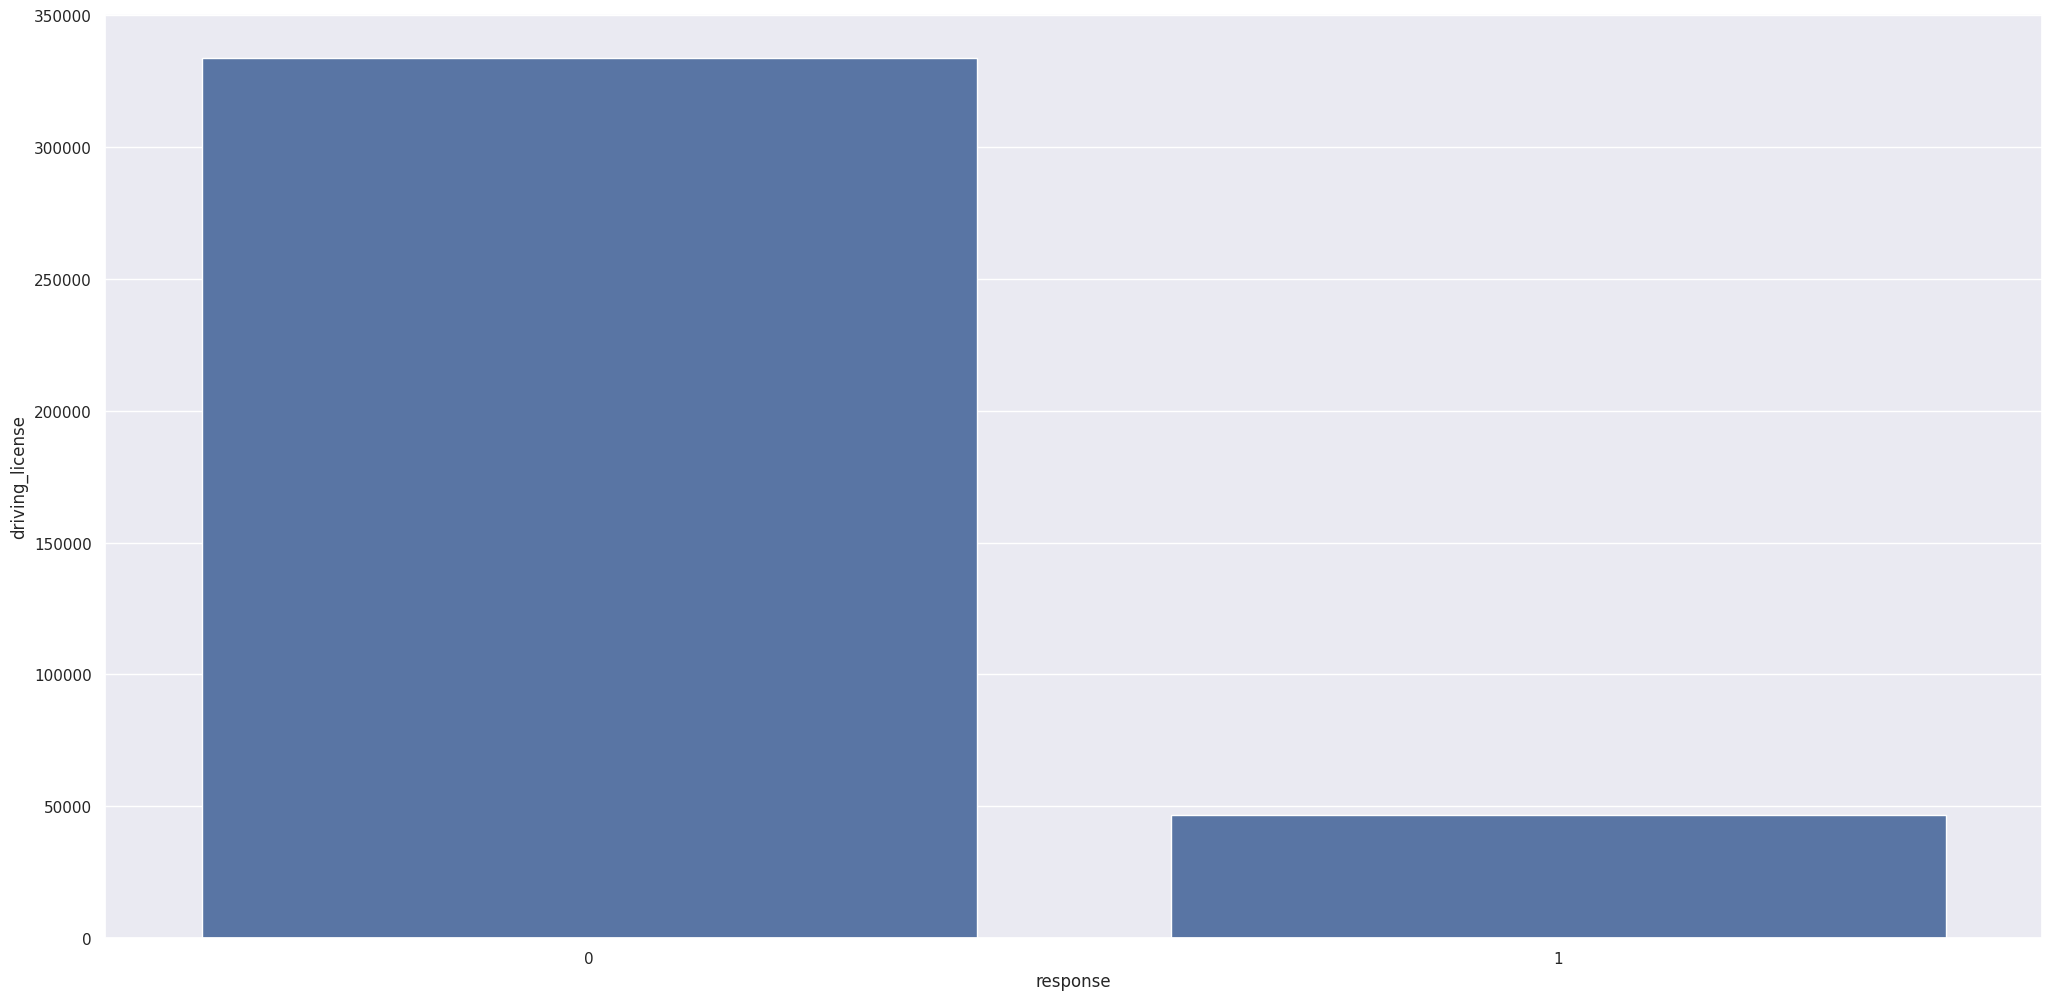

In [ ]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()

sns.barplot(x='response', y='driving_license', data=aux)

H3. Clientes que sofreram dano em seu veículo têm maior chance de aceitar a proposta de seguro. VERDADE

In [ ]:
pd.crosstab(df4['vehicle_damage'], df4['response'])

response,0,1
vehicle_damage,,
0,187714,982
1,146685,45728


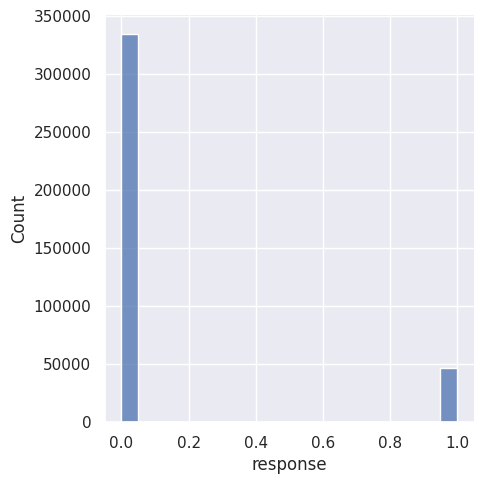

In [ ]:
sns.displot(df4['response'])

In [ ]:
df4['vehicle_age'].value_counts()

,count
vehicle_age,
between_1_2_year,200316
below_1_year,164786
over_2_years,16007


In [ ]:
df4['gender'].value_counts()

,count
gender,
Male,206089
Female,175020


#### Bivariate Analysis

H1. Donos de carros comprados recentemente (veículos mais novos) aceitam seguros mais facilmente.

FALSO - Donos de veículos novos tendem a não aceitar seguros



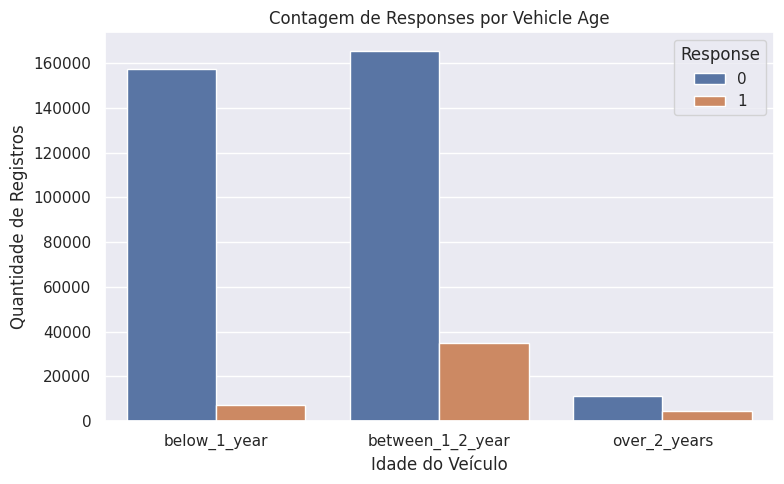

In [ ]:
aux = df4[['vehicle_age', 'response', 'id']].groupby(['vehicle_age', 'response']).count().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=aux, x='vehicle_age', y='id', hue='response')

plt.title('Contagem de Responses por Vehicle Age')
plt.xlabel('Idade do Veículo')
plt.ylabel('Quantidade de Registros')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

Mulheres tendem a aceitar seguros de carro mais facilmente, se comparados a homens.

FALSO - Homens aceitam mais seguros

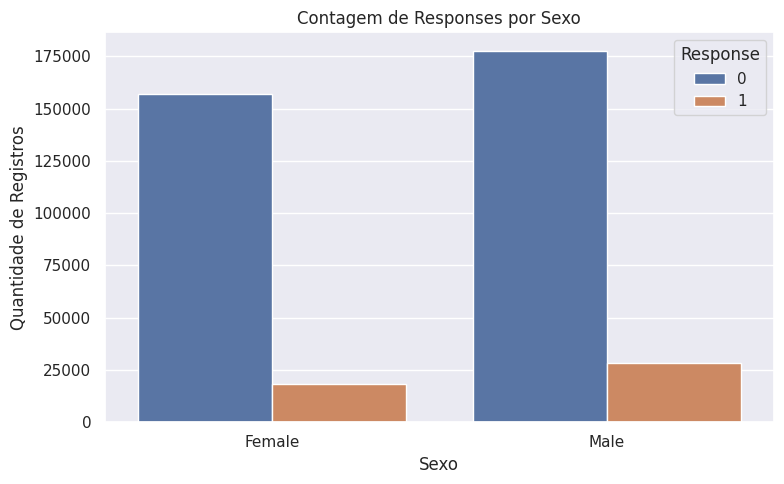

In [ ]:
aux = df4[['gender', 'response', 'id']].groupby(['gender', 'response']).count().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=aux, x='gender', y='id', hue='response')

plt.title('Contagem de Responses por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Quantidade de Registros')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

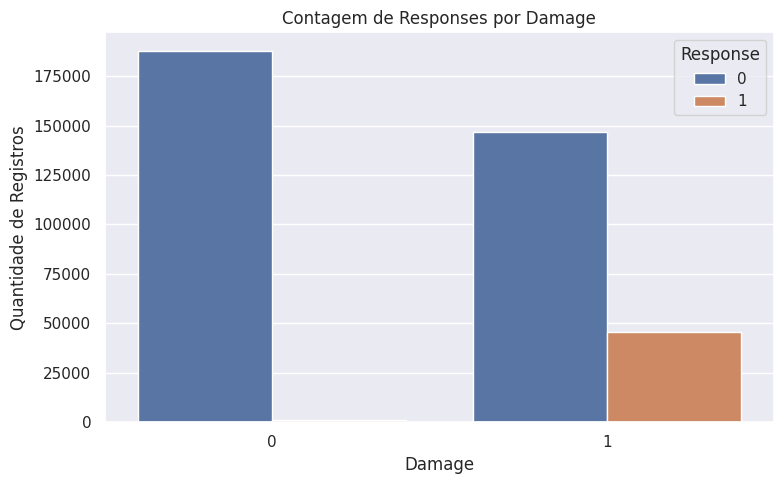

In [ ]:
aux = df4[['vehicle_damage', 'response', 'id']].groupby(['vehicle_damage', 'response']).count().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=aux, x='vehicle_damage', y='id', hue='response')

plt.title('Contagem de Responses por Damage')
plt.xlabel('Damage')
plt.ylabel('Quantidade de Registros')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

H4. Clientes que ainda não possuem seguro têm maior taxa de conversão. VERDADE

In [ ]:
pd.crosstab(df4['previously_insured'], df4['response'])

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


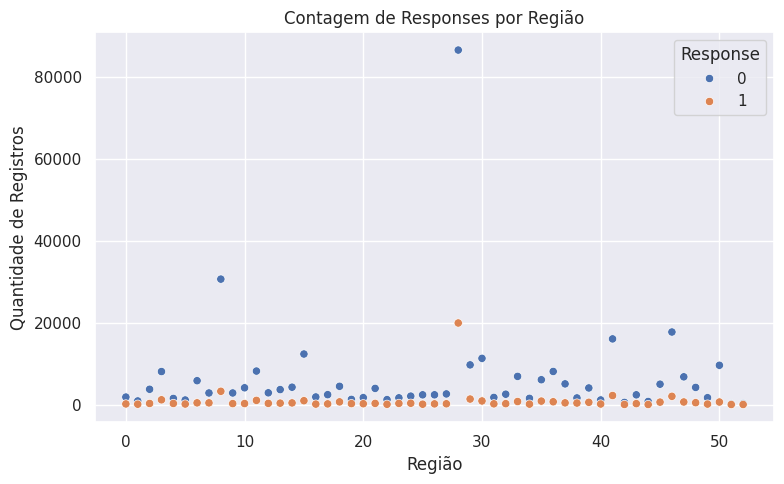

In [ ]:
aux = df4[['region_code', 'response', 'id']].groupby(['region_code', 'response']).count().reset_index()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=aux, x='region_code', y='id', hue='response')

plt.title('Contagem de Responses por Região')
plt.xlabel('Região')
plt.ylabel('Quantidade de Registros')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

H5. Clientes com maior tempo de relacionamento  têm maior propensão a aceitar o seguro.

FALSA - Cleintes mais antigos tendem a não aceitar novas propostas de seguro

<Axes: xlabel='response', ylabel='vintage'>

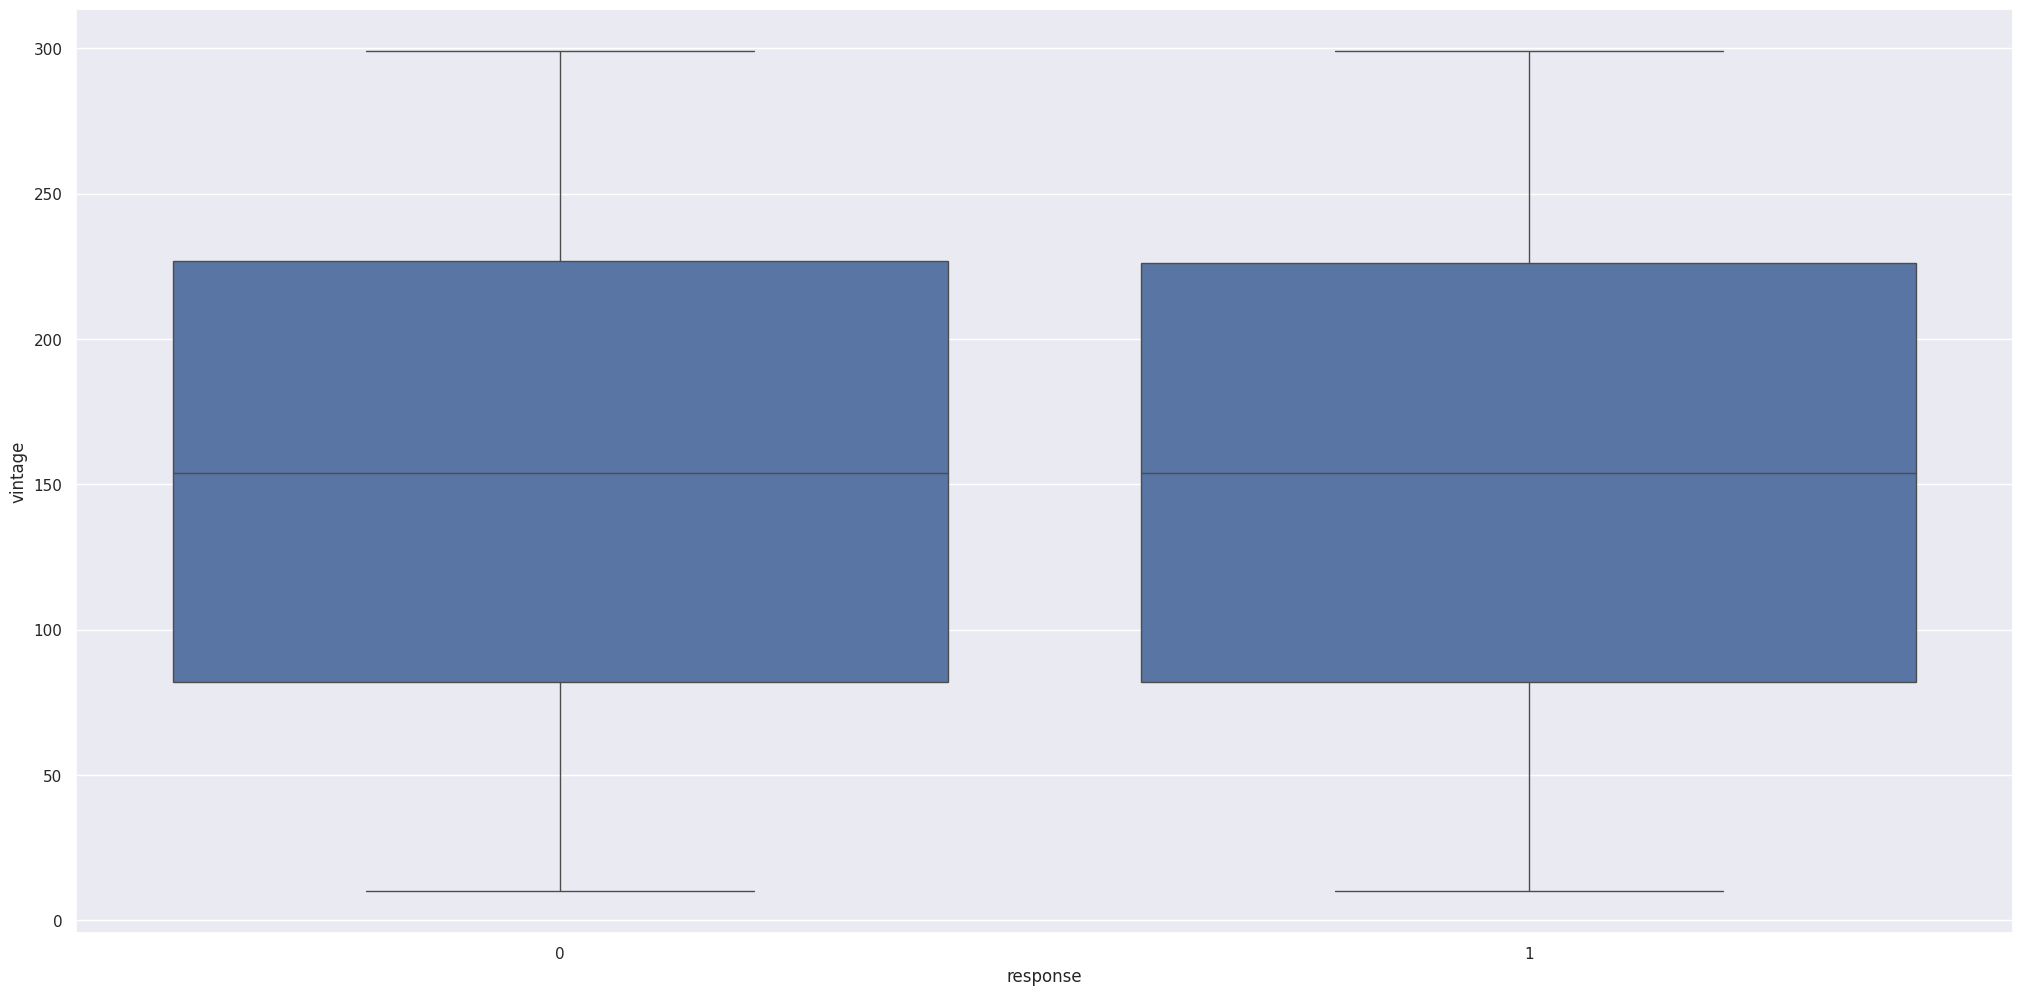

In [ ]:
sns.boxplot(data=df4, x='response', y='vintage')

<Axes: xlabel='response', ylabel='policy_sales_channel'>

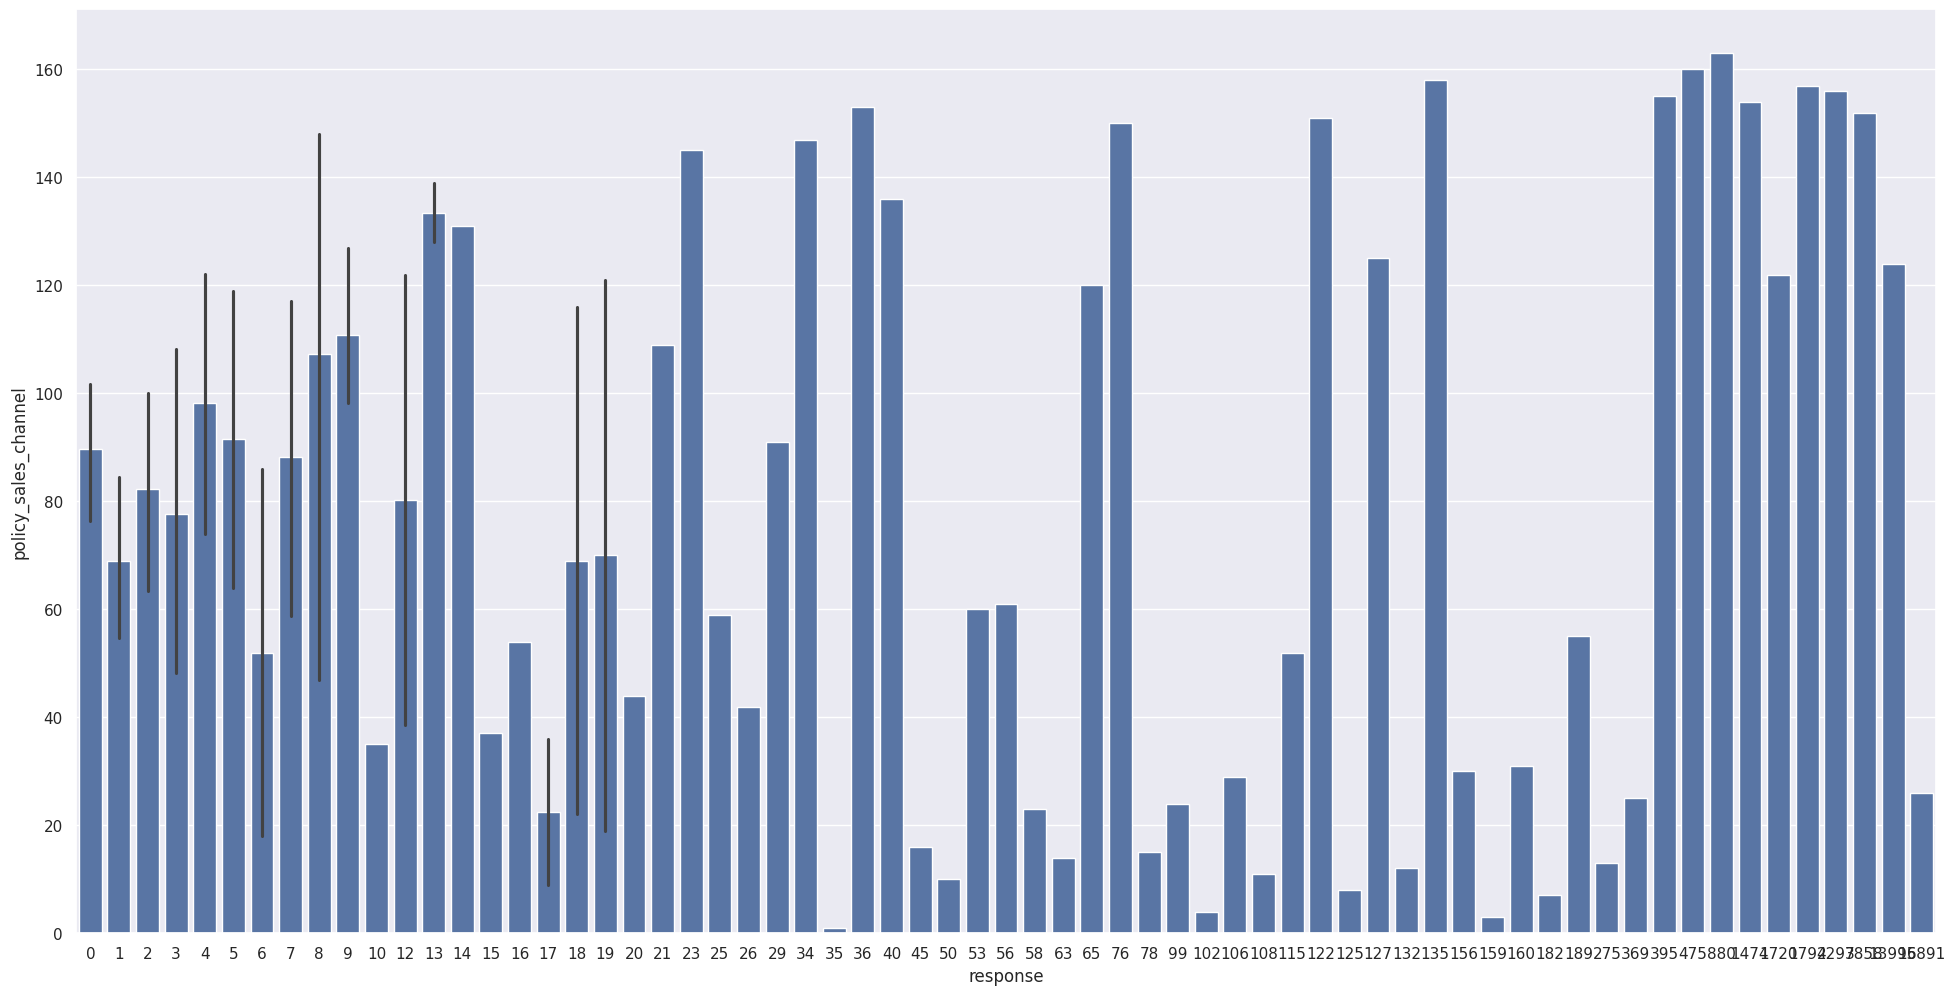

In [ ]:
plt.figure(figsize=(24, 12))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()

sns.barplot(data=aux, x='response', y='policy_sales_channel')

#### Multivariate Analysis

<Axes: >

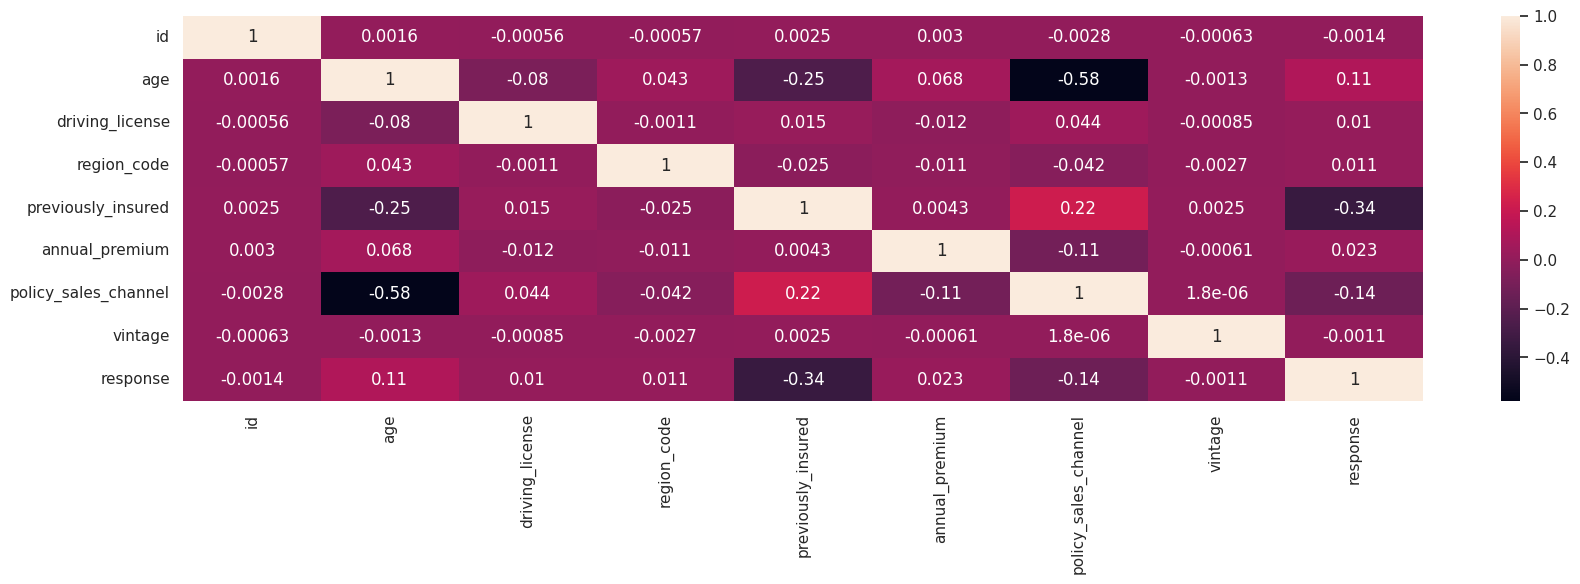

In [ ]:
corr = num_attributes.corr(method='pearson')

plt.figure(figsize=(20,5))
sns.heatmap(corr, annot=True)

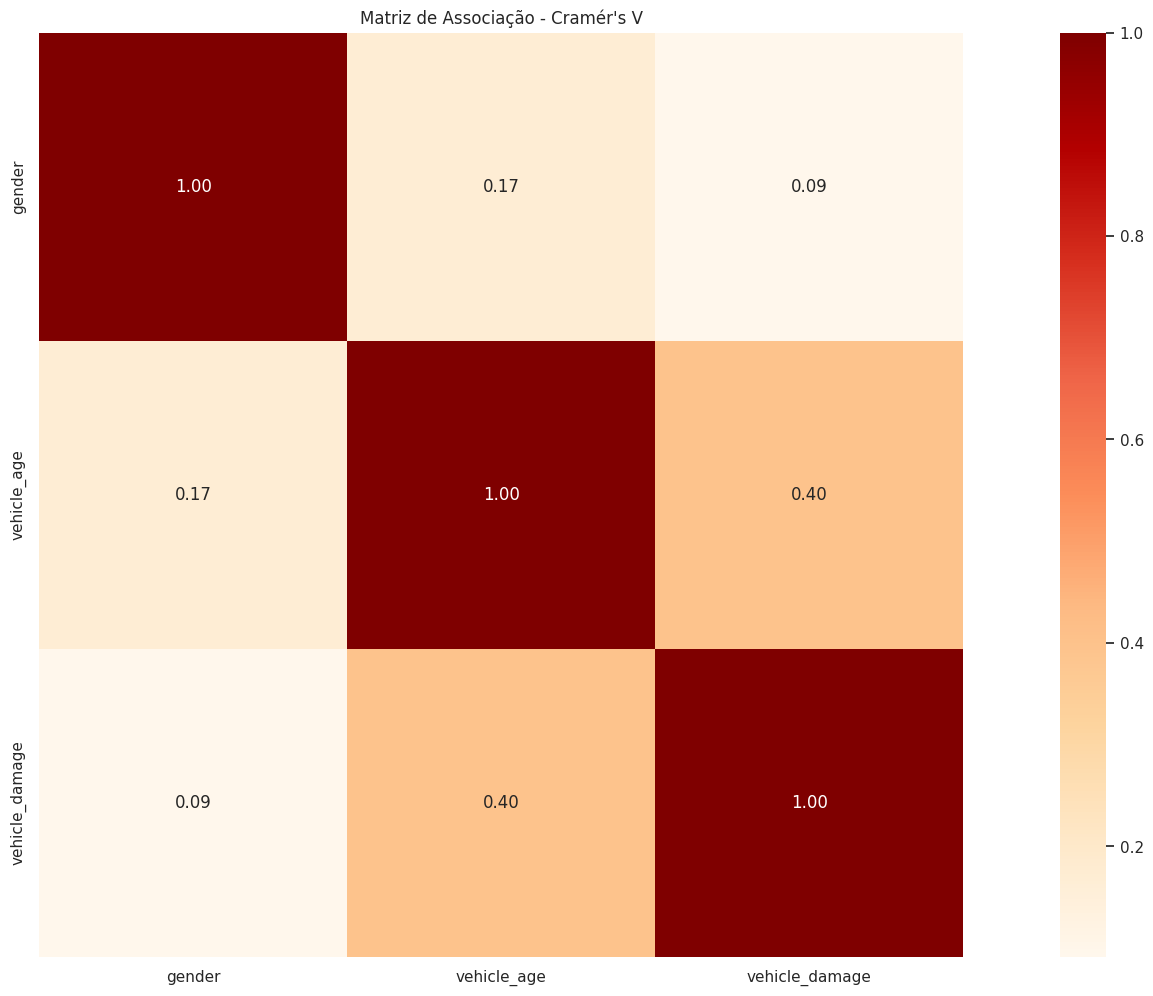

In [ ]:
cramer_matrix = cramers_v_matrix(cat_attributes)

sns.heatmap(cramer_matrix, annot=True, cmap='OrRd', fmt=".2f", square=True)
plt.title("Matriz de Associação - Cramér's V")
plt.show()


## Data Preparation

In [150]:
df5 = df4.copy()

#df5 = df5.drop(columns=['premium_bin'])

In [151]:
X = df5.drop(columns=['response'])

y = df5['response'].copy()

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

df5 = pd.concat([X_train, y_train], axis=1)

In [50]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
371559,371560,Female,23,1,33.0,1,below_1_year,0,39028.0,152.0,220,0
125330,125331,Male,25,1,14.0,0,between_1_2_year,1,2630.0,124.0,251,0
182773,182774,Female,22,1,43.0,1,below_1_year,0,36916.0,152.0,12,0
43311,43312,Female,36,1,18.0,1,between_1_2_year,0,2630.0,156.0,42,0
221849,221850,Male,23,1,7.0,0,below_1_year,1,47936.0,26.0,287,0


#### Standardization

In [152]:
#annual_premium
ss = StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

pickle.dump(ss, open('annual_premium_scaler.pkl', 'wb'))

#### Rescaling (Min-Max)

In [153]:
#Age
mm_age = MinMaxScaler()
df5['age'] = mm_age.fit_transform(df5[['age']].values)

pickle.dump(mm_age, open('age_scaler.pkl', 'wb'))

#vintage
mm_vintage = MinMaxScaler()
df5['vintage'] = mm_vintage.fit_transform(df5[['vintage']].values)

pickle.dump(mm_vintage, open('vintage_scaler.pkl', 'wb'))

#### Enconder

In [154]:
#region_code	- Target Enconding
tg_rg = ce.TargetEncoder(cols=['region_code'])
df5['region_code'] = tg_rg.fit_transform(df5[['region_code']], df5['response'])

pickle.dump(tg_rg, open('region_code_scaler.pkl', 'wb'))

#vehicle_age - Ordinal Enconding
categories = [['below_1_year', 'between_1_2_year', 'over_2_years']]
oe = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
df5['vehicle_age'] = oe.fit_transform(df5[['vehicle_age']])

pickle.dump(oe, open('vehicle_age_scaler.pkl', 'wb'))

#gender - Label Enconding
le = LabelEncoder()
df5['gender'] = le.fit_transform(df5['gender'])

pickle.dump(le, open('gender_scaler.pkl', 'wb'))

#policy_sales_channel	- Target encoding
tg_ps = ce.TargetEncoder(cols=['policy_sales_channel'])
df5['policy_sales_channel'] = tg_ps.fit_transform(df5[['policy_sales_channel']], df5['response'])

pickle.dump(tg_ps, open('policy_sales_scaler.pkl', 'wb'))

In [54]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
371559,371560,0,0.046154,1,0.102284,1,0.0,0,0.491176,0.028939,0.726644,0
125330,125331,1,0.076923,1,0.087840,0,1.0,1,-1.622961,0.188735,0.833910,0
182773,182774,0,0.030769,1,0.093168,1,0.0,0,0.368503,0.028939,0.006920,0
43311,43312,0,0.246154,1,0.136996,1,1.0,0,-1.622961,0.217457,0.110727,0
221849,221850,1,0.046154,1,0.133609,0,0.0,1,1.008587,0.199034,0.958478,0


#### Validation Preparation

In [55]:
X_validation['annual_premium'] = ss.transform(X_validation[['annual_premium']].values)

X_validation['age'] = mm_age.transform(X_validation[['age']].values)

X_validation['vintage'] = mm_vintage.transform(X_validation[['vintage']].values)

X_validation['region_code'] = tg_rg.transform(X_validation[['region_code']])

X_validation['policy_sales_channel'] = tg_ps.transform(X_validation[['policy_sales_channel']])

X_validation['vehicle_age'] = oe.transform(X_validation[['vehicle_age']])

X_validation['gender'] = le.transform(X_validation['gender'])

In [56]:
X_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
105064,105065,1,0.523077,1,0.186628,1,1.0,0,1.073525,0.199034,0.913495
294134,294135,0,0.615385,1,0.186628,0,1.0,0,-1.622961,0.187919,0.889273
234054,234055,0,0.338462,1,0.071766,0,1.0,1,-0.002363,0.199034,0.439446
280529,280530,1,0.369231,1,0.124099,0,1.0,1,0.135819,0.199034,0.352941
16360,16361,1,0.215385,1,0.119506,0,1.0,1,-1.622961,0.217457,0.062284


## Feature Selection

#### Features Importance

In [ ]:
'''rf = RandomForestClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = df5.drop(columns=['id', 'response'])
y_train_n = y_train.values

rf.fit(x_train_n, y_train_n)'''

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:


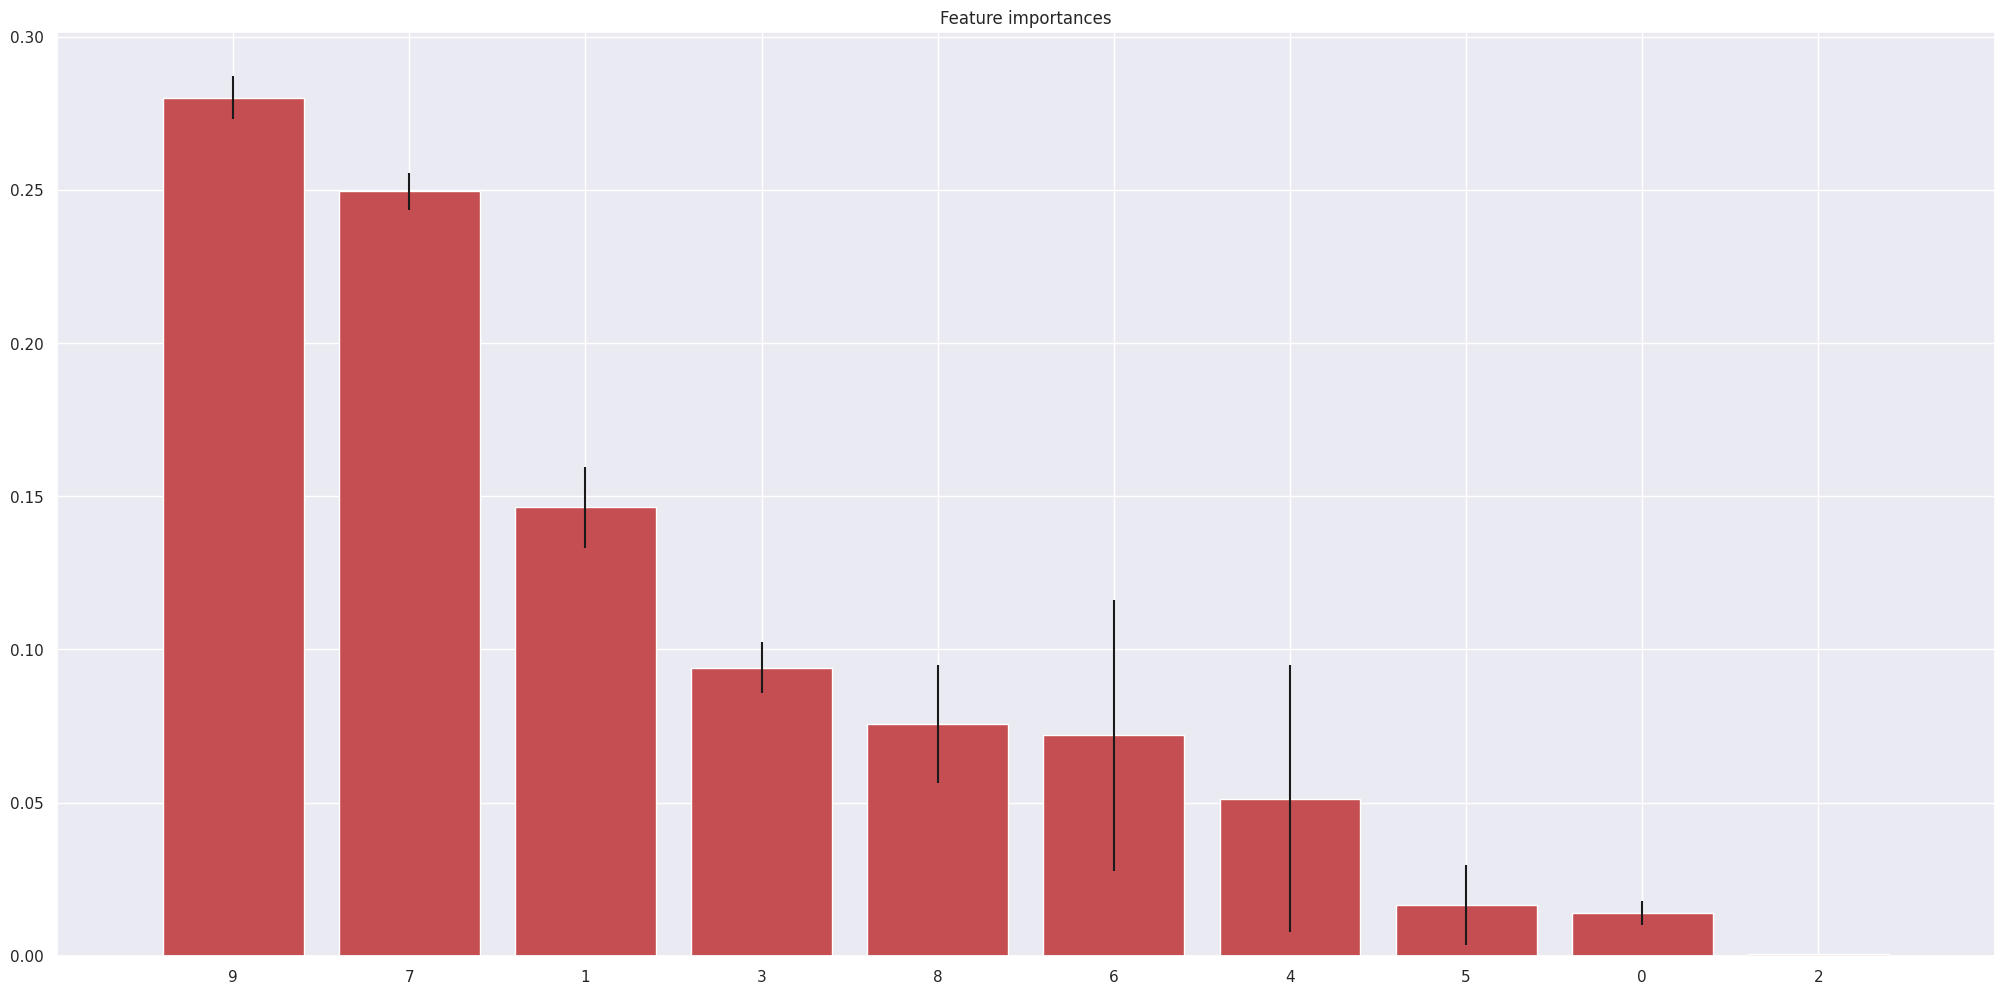

,feature,importance
0,vintage,0.280123
0,annual_premium,0.249452
0,age,0.146384
0,region_code,0.093995
0,policy_sales_channel,0.075712
0,vehicle_damage,0.071961
0,previously_insured,0.051257
0,vehicle_age,0.016620
0,gender,0.013949
0,driving_license,0.000548


In [ ]:
'''importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, rf.feature_importances_):
    aux = pd.DataFrame({ 'feature': i, 'importance': j }, index=[0])
    df = pd.concat([df, aux], axis=0)


plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


df.sort_values('importance', ascending=False)'''

#### Manual Selection

In [57]:
cols_selected_manual = ['vintage', 'annual_premium',	'age',	'region_code',	'policy_sales_channel',	'vehicle_damage',	'previously_insured']

X_train = X_train[cols_selected_manual]

X_val = X_validation[cols_selected_manual]

y_val = y_validation.copy()

## Machine Learning Model

#### KNN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)

#model training
knn_model.fit(X_train, y_train)

#model prediction - Generalization
yhat_knn = knn_model.predict_proba(X_val)

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

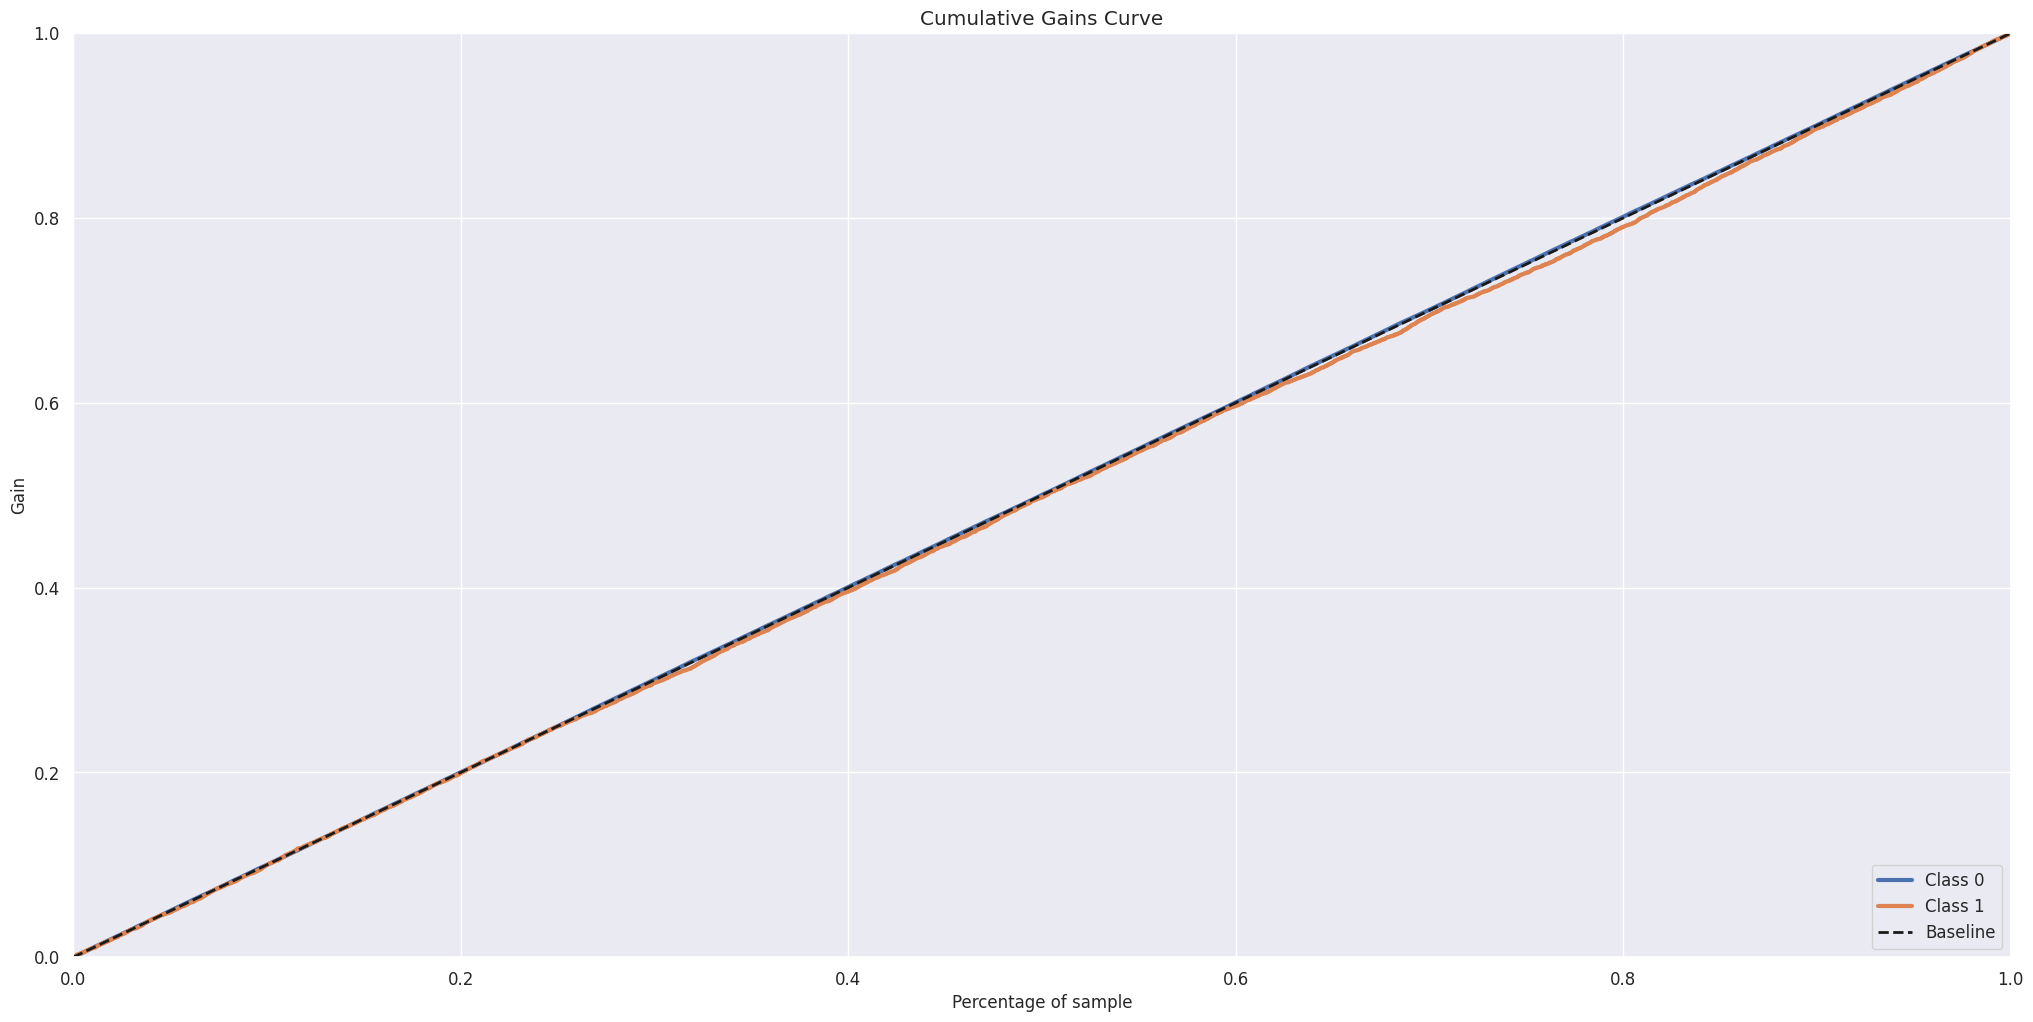

In [ ]:
#Acumulative Gain
plot_cumulative_gain(y_val, yhat_knn)

#### Naive Bayes

In [ ]:
nb_model = GaussianNB()

#model training
nb_model.fit(X_train, y_train)

#model prediction - Generalization
yhat_nb = nb_model.predict_proba(X_val)

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

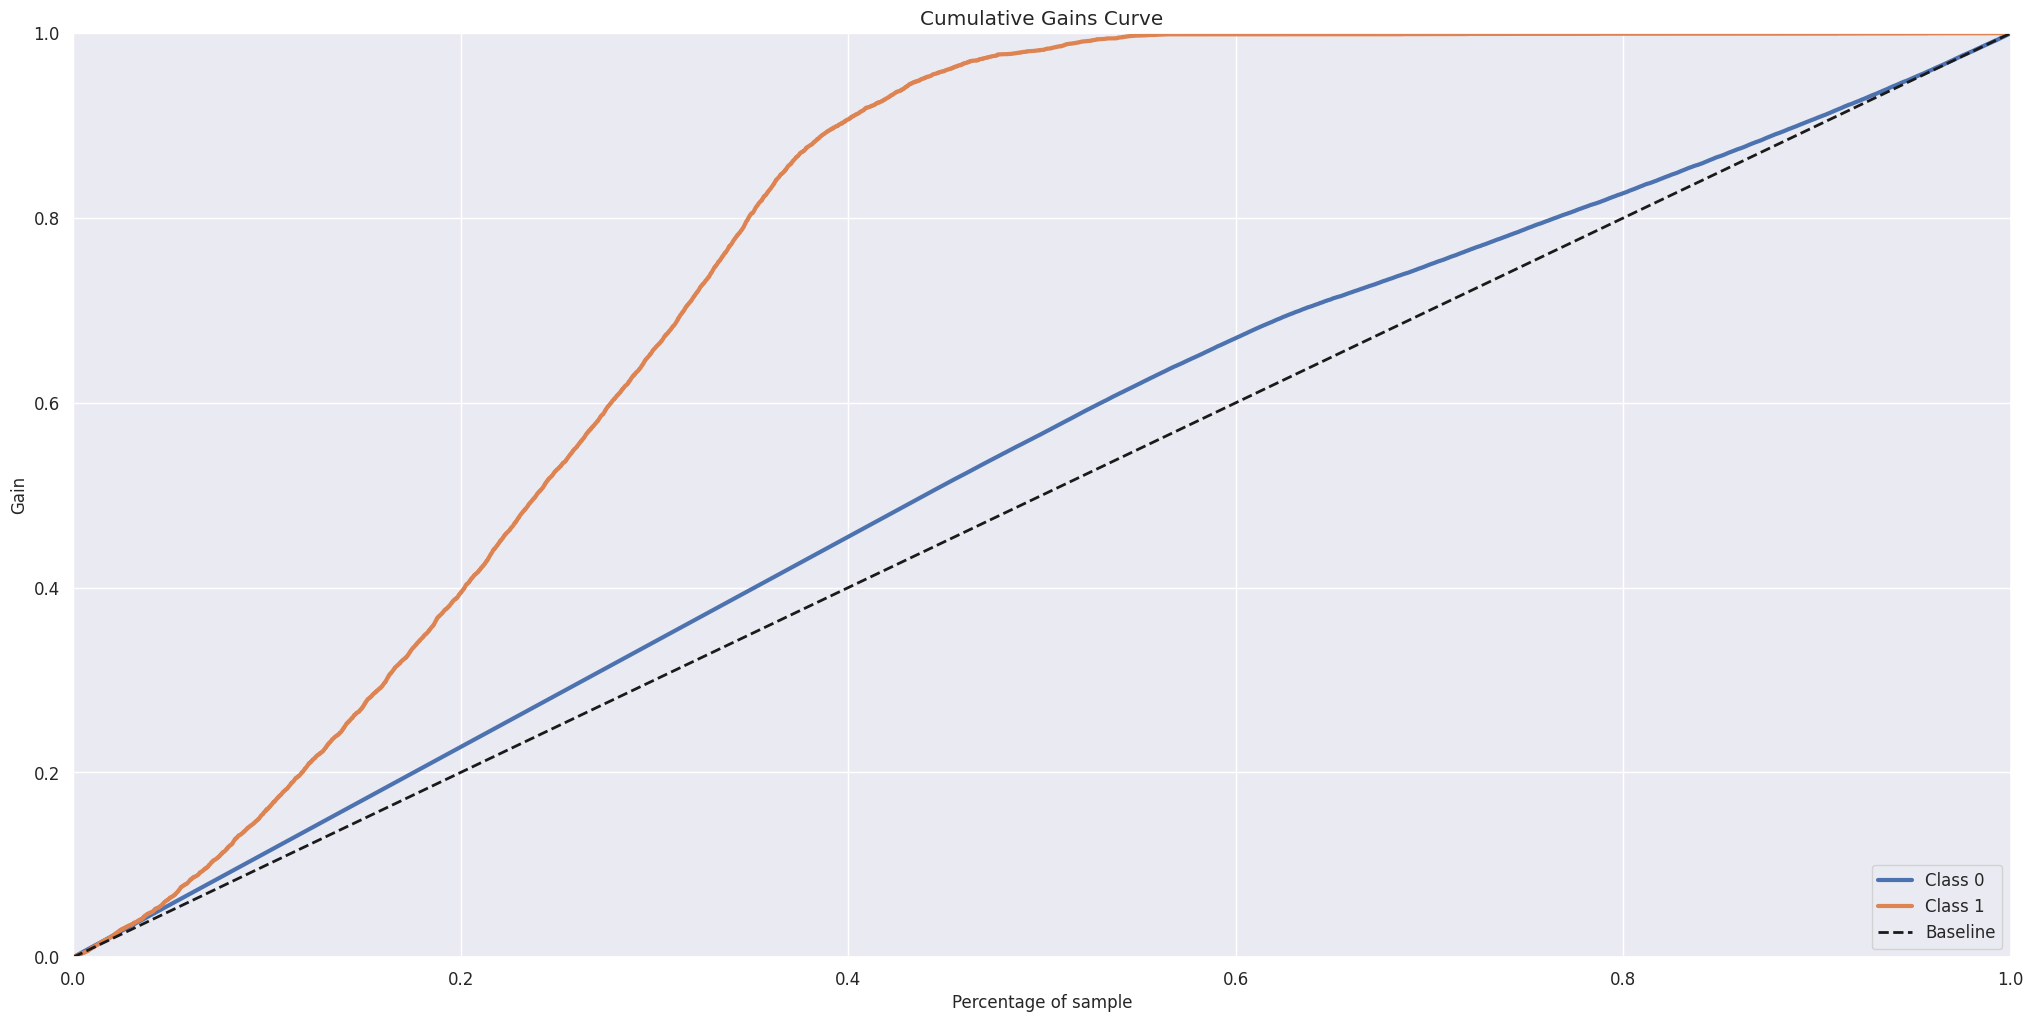

In [ ]:
#Acumulative Gain
plot_cumulative_gain(y_val, yhat_nb)

#### Logistic Regression

In [ ]:
lr_model = LogisticRegression()

#model training
lr_model.fit(X_train, y_train)

#model prediction - Generalization
yhat_lr = lr_model.predict_proba(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

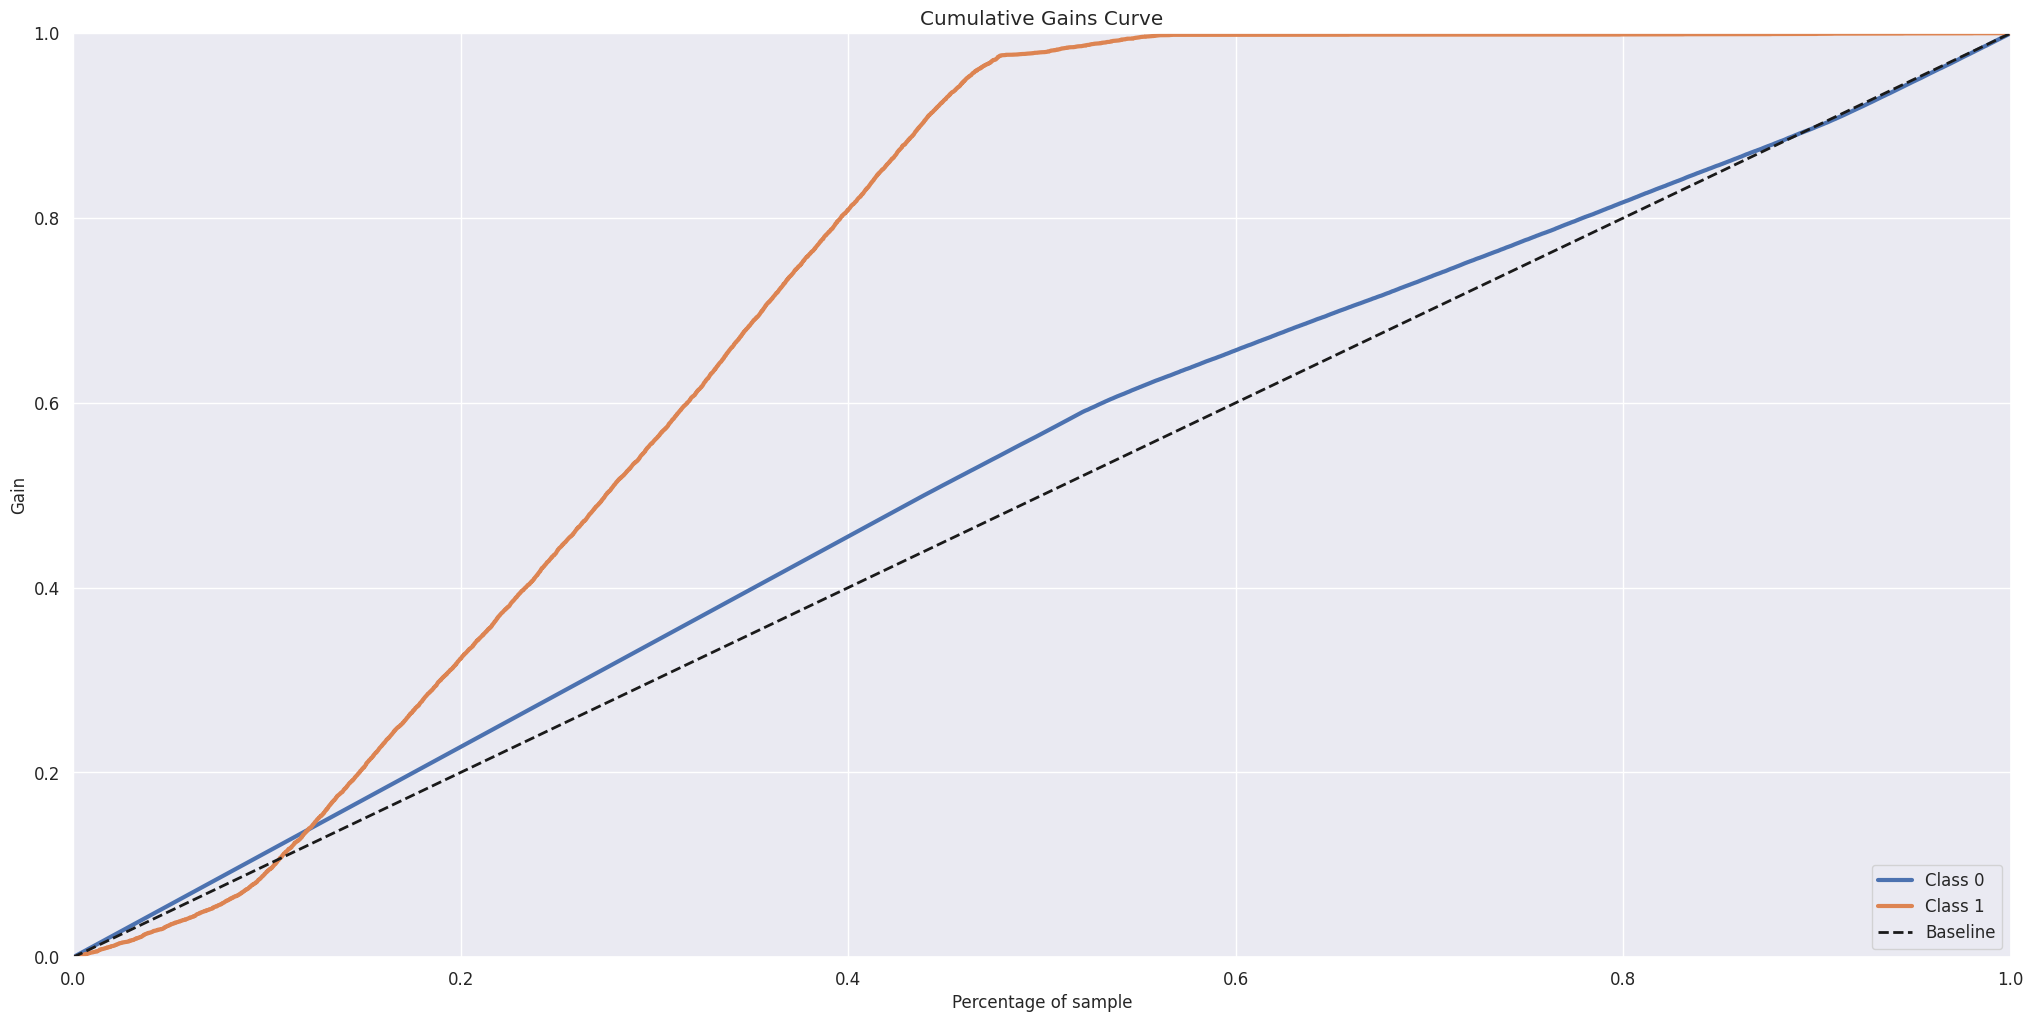

In [ ]:
#Acumulative Gain
plot_cumulative_gain(y_val, yhat_lr)

In [ ]:
y_proba = pd.Series(yhat_lr[:, 1])

# Precision nos top 50%
precision_k50 = precision_at_k(y_val, y_proba, k=0.55)
print(f"Precision@50%: {precision_k50:.4f}")

recall_k50 = recall_at_k(y_val, y_proba, k=0.55)
print(f"Recall@50%: {recall_k50:.4f}")

Precision@50%: 0.2209
Recall@50%: 0.9955


#### Random Forest

In [ ]:
rf_model = RandomForestClassifier()

#model training
rf_model.fit(X_train, y_train)

#model prediction - Generalization
yhat_rf = rf_model.predict_proba(X_val)

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

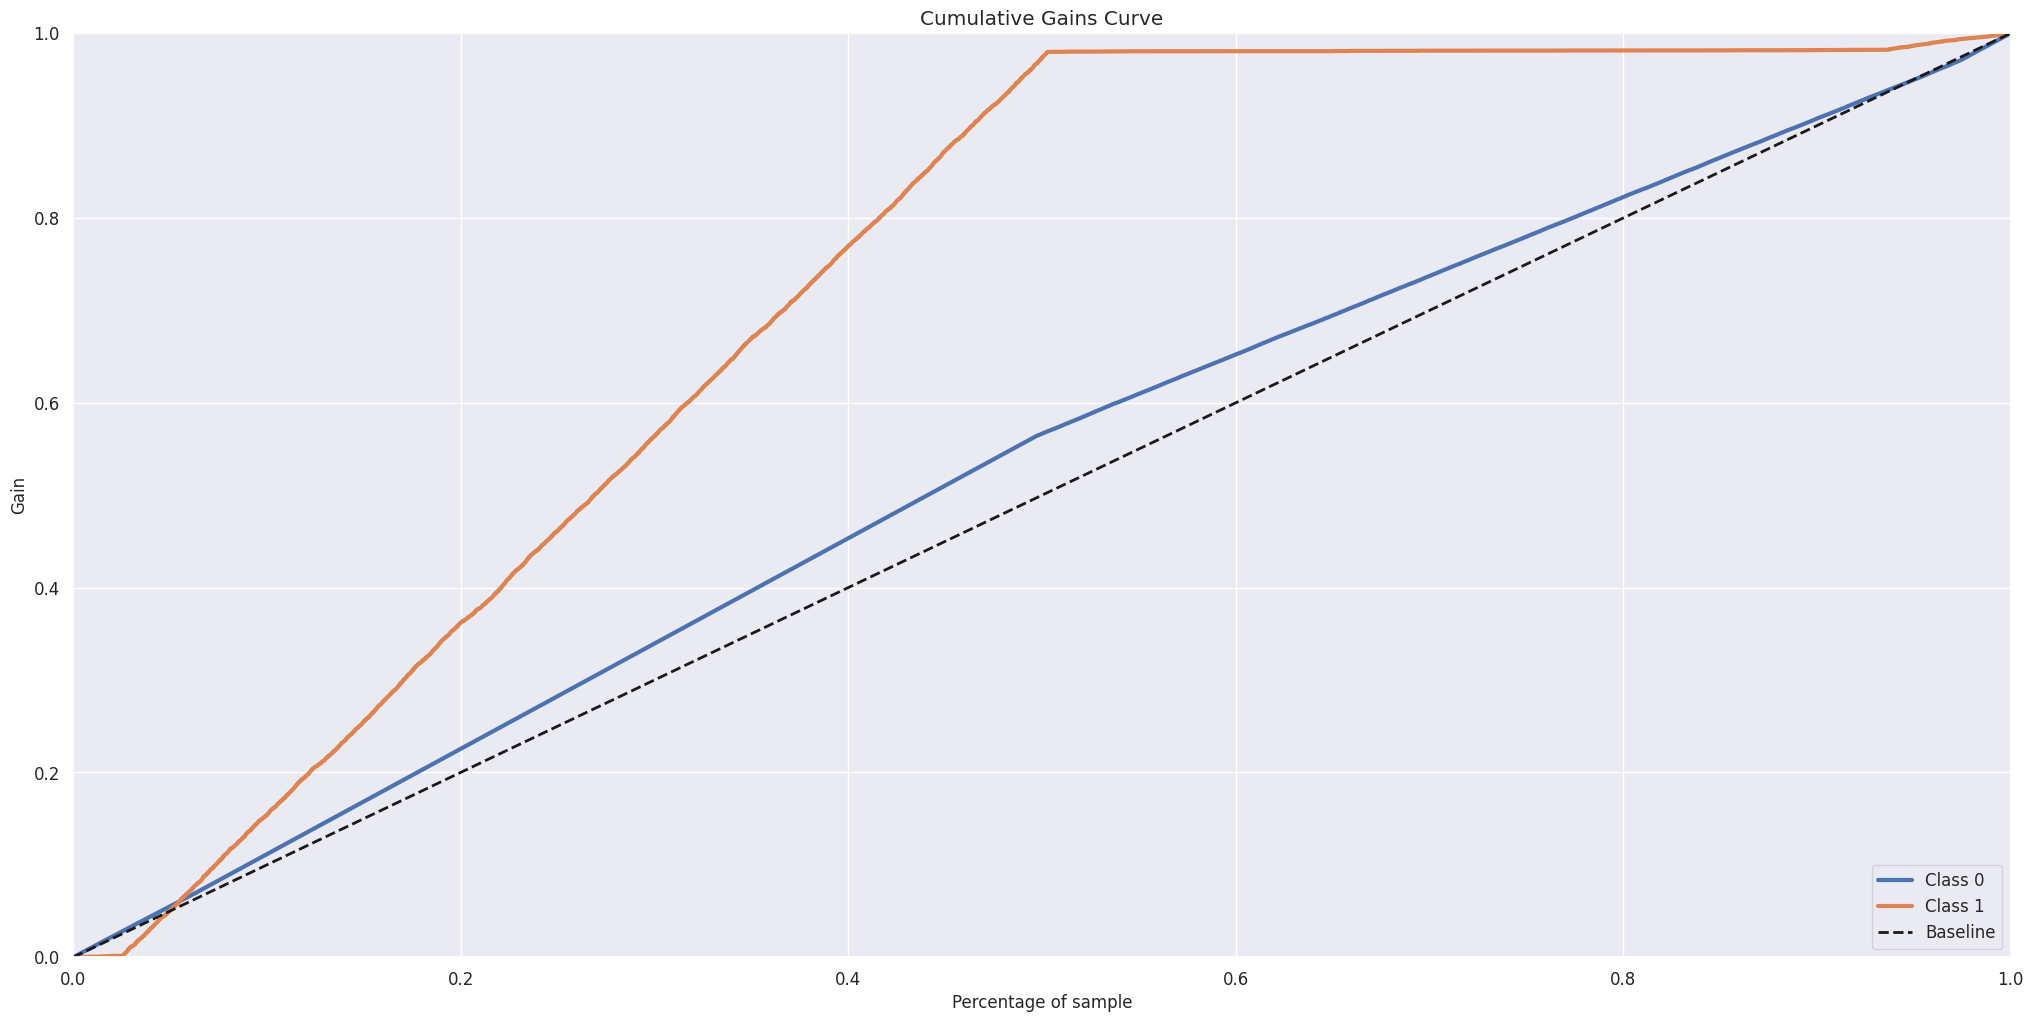

In [ ]:
#Acumulative Gain
plot_cumulative_gain(y_val, yhat_rf)

#### Balanced Random Forest

In [ ]:
brf_model =  BalancedRandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    sampling_strategy='auto',
    random_state=42,
    class_weight='balanced'
)
#model training
brf_model.fit(X_train, y_train)

#model prediction - Generalization
yhat_brf = brf_model.predict_proba(X_val)

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

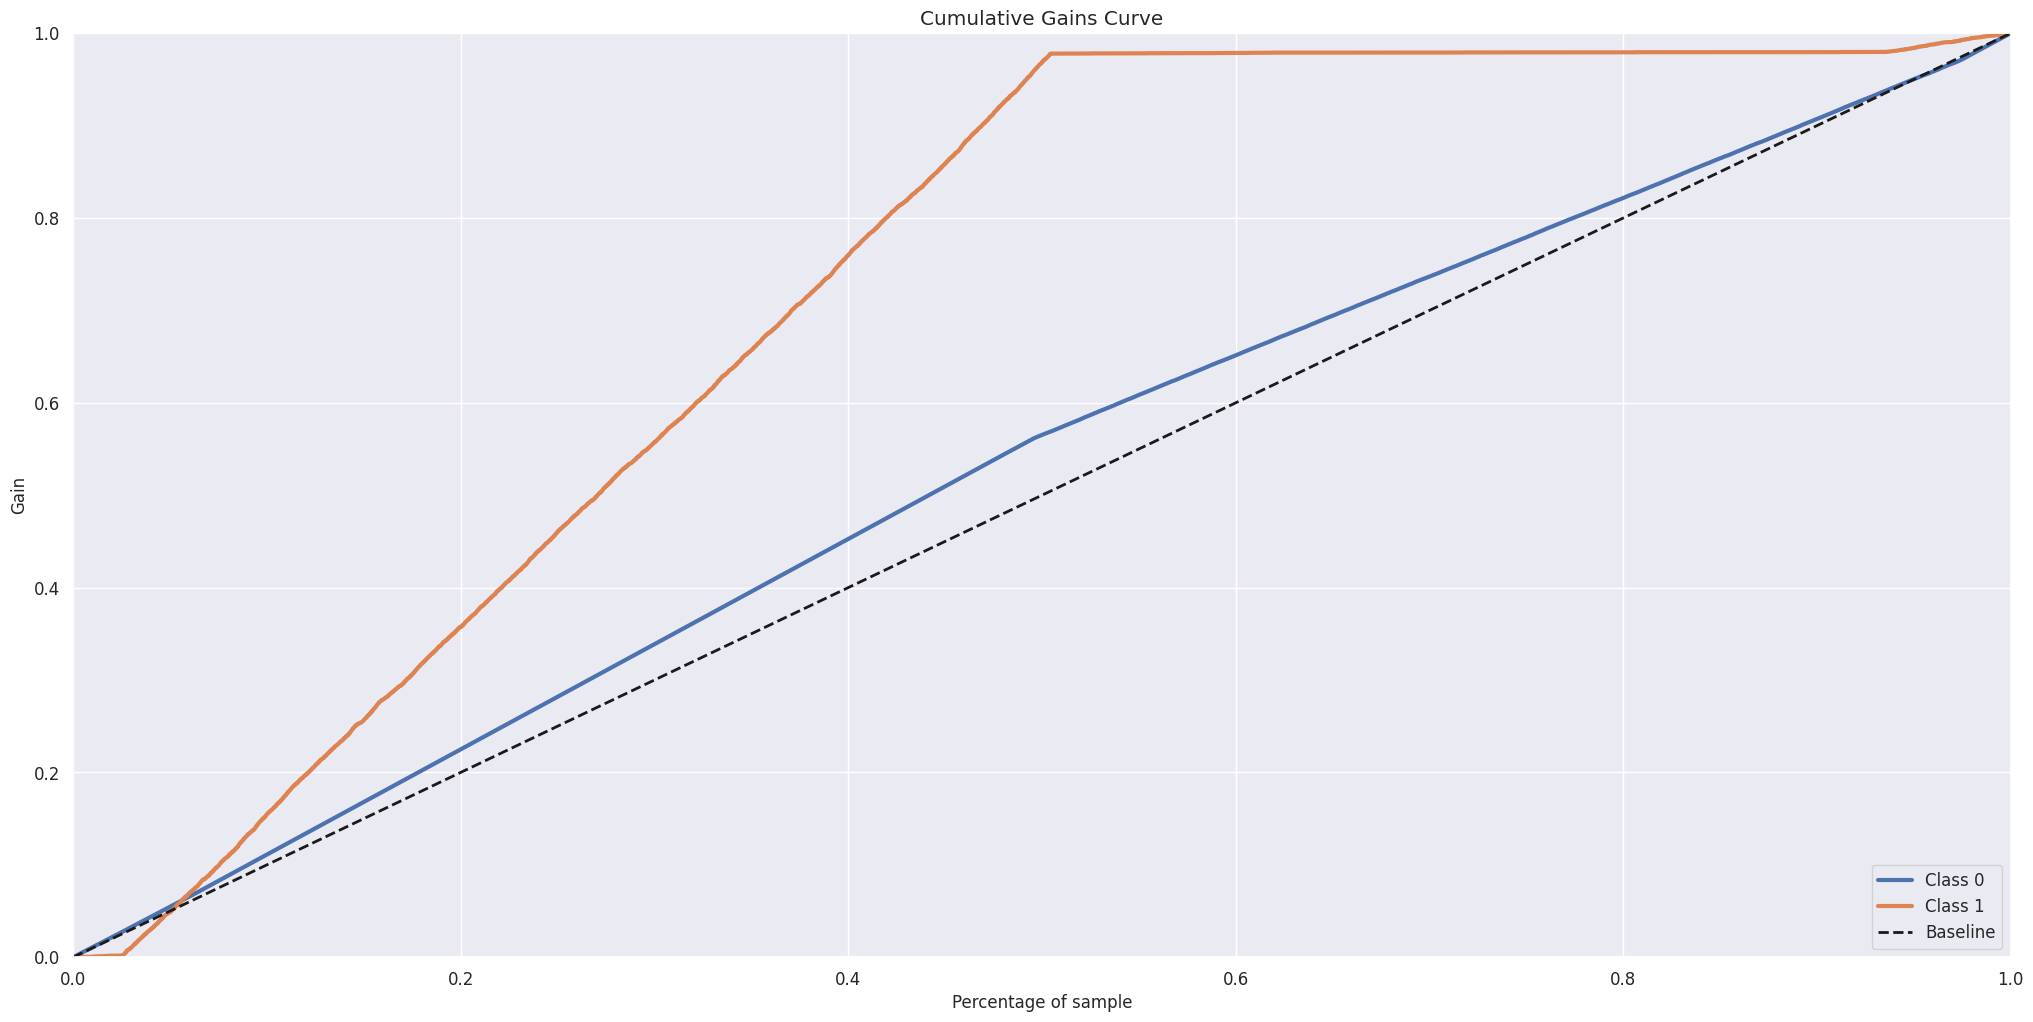

In [ ]:
plot_cumulative_gain(y_val, yhat_brf)

#### Regression Logistic with Balanced Data

In [66]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [67]:
lr_model = LogisticRegression()

#model training
lr_model.fit(X_resampled, y_resampled)

#model prediction - Generalization
yhat_balanced = lr_model.predict_proba(X_val)

\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  l2_reg_strength = 1.0 / (C * sw_sum)


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

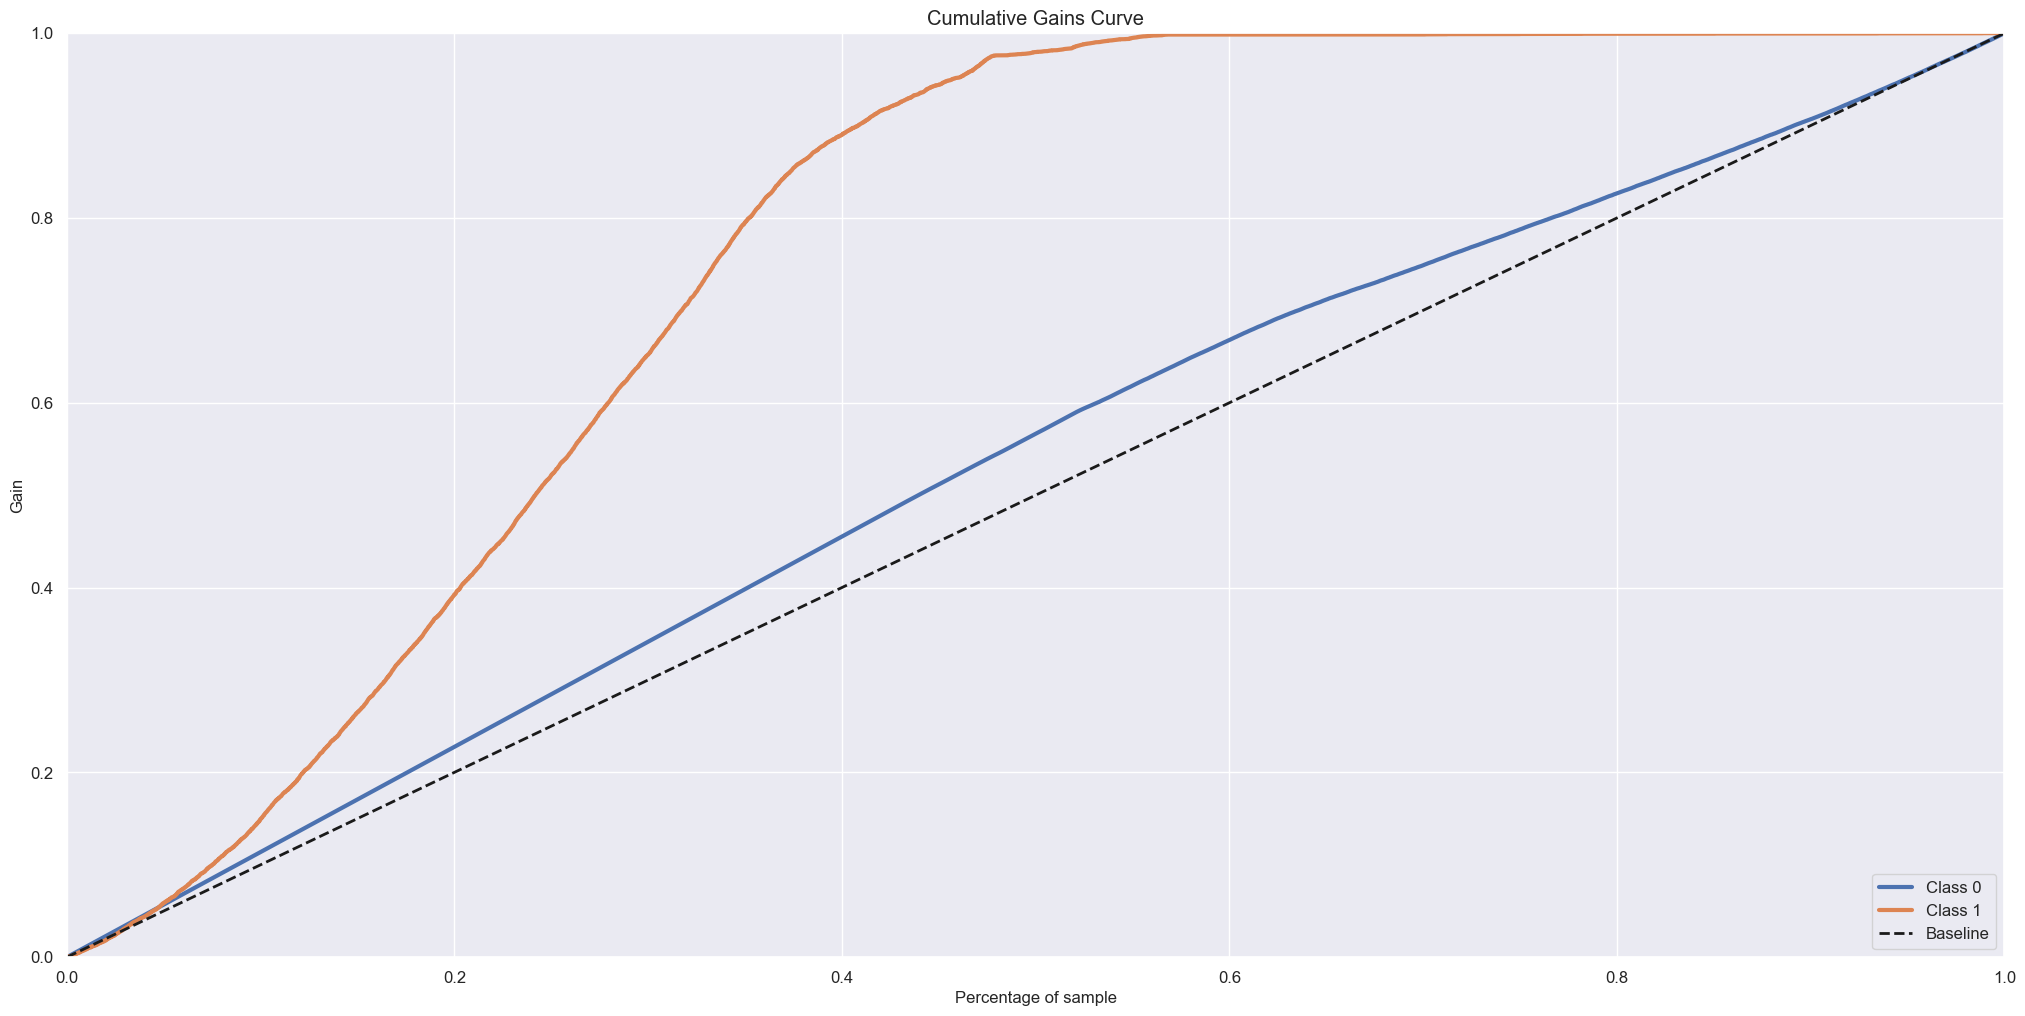

In [68]:
plot_cumulative_gain(y_val, yhat_balanced)

In [69]:
y_proba = pd.Series(yhat_balanced[:, 1])

# Precision nos top 50%
precision_k50 = precision_at_k(y_val, y_proba, k=0.50)
print(f"Precision@50%: {precision_k50:.4f}")

recall_k50 = recall_at_k(y_val, y_proba, k=0.50)
print(f"Recall@50%: {recall_k50:.4f}")

Precision@50%: 0.2384
Recall@50%: 0.9795


#### Cross-Validation

In [70]:
scores, mean, std = cross_validation(
    lr_model,
    X_train,
    y_train,
    k=0.5
)

\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  l2_reg_strength = 1.0 / (C * sw_sum)
\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data 

Recall@50% médio: 0.7705
Desvio padrão: 0.1397


\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  l2_reg_strength = 1.0 / (C * sw_sum)


In [71]:
print(f'Média Recall: {mean:.4f}')

print('Lista Recall:', ['{:.4f}'.format(s) for s in scores])

Média Recall: 0.7705
Lista Recall: ['0.6948', '0.6424', '0.9833', '0.6433', '0.8886']


In [72]:
param_tuned = {
    'penalty': 'l1',
    'l1_ratio': 0.25,
    'C': 1,
    'solver': 'liblinear',
    'max_iter': 1000
}

logreg_model = LogisticRegression(**param_tuned)
smote = SMOTE(random_state=42)

precision_scores, recall_scores, mean_precision, mean_recall = cross_val_precision_recall_at_k_pipeline(
    X_train, y_train, logreg_model, smote, k=0.5
)

\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  
\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  
\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  
\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  
\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_log

Recall@50% médio com CV: 0.9829 ± 0.0017
Precision@50% médio com CV: 0.2414 ± 0.0004


## Fine-Tunning

####  Randomized Search

In [ ]:
'''param = {
    'n_estimators': randint(50, 200),         # número de árvores
    'max_depth': randint(5, 20),                # profundidade máxima
    'min_samples_split': randint(2, 20),        # min amostras para split
    'max_features': ['sqrt'],     # número de features em cada split            # uso de bootstrap
}'''

In [ ]:
#Validação cruzada estratificada
'''cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator= rf_model,
    param_distributions=param,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)'''

In [ ]:
("Best's hyperparameters:")
print(random_search.best_params_)

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 171}


## Final Model

#### Train Final Model

In [73]:
param_tuned = {
    'penalty': 'l1',
    'l1_ratio': 0.25,
    'C': 1,
    'solver': 'liblinear',
    'max_iter': 1000,
}

#Random Forest {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 171}

In [74]:
final_model = LogisticRegression(penalty=param_tuned['penalty'],
                                 l1_ratio=param_tuned['l1_ratio'],
                                 C=param_tuned['C'],
                                 solver=param_tuned['solver'],
                                 max_iter=param_tuned['max_iter']
                                 )

final_model.fit(X_resampled, y_resampled)

#prediction
yhat_final = final_model.predict_proba(X_val)


'''RandomForestClassifier(max_depth=param_tuned['max_depth'],
                                 max_features=param_tuned['max_features'],
                                 min_samples_split=param_tuned['min_samples_split'],
                                 n_estimators=param_tuned['n_estimators'],
                                 )'''

\\?\C:\Users\mlfarias\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  


"RandomForestClassifier(max_depth=param_tuned['max_depth'],\n                                 max_features=param_tuned['max_features'],\n                                 min_samples_split=param_tuned['min_samples_split'],\n                                 n_estimators=param_tuned['n_estimators'],\n                                 )"

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

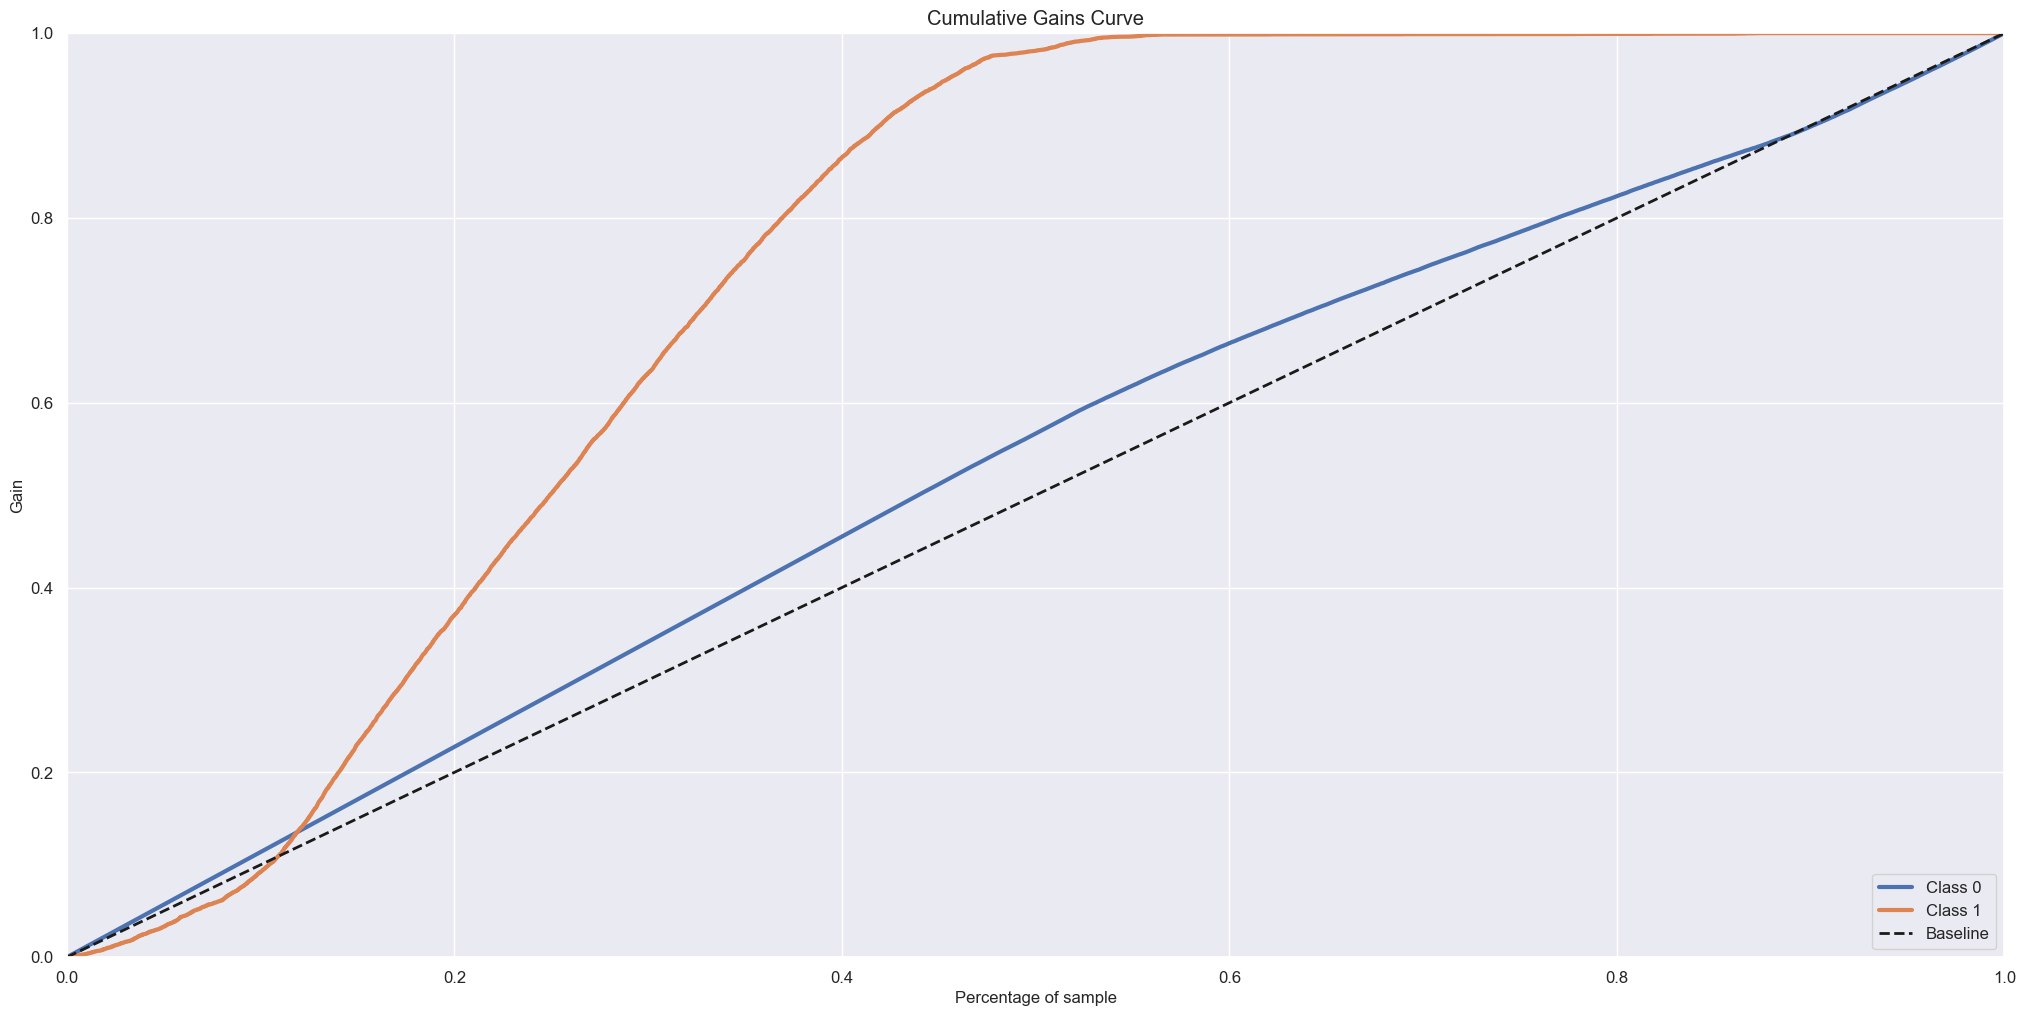

In [75]:
plot_cumulative_gain(y_val, yhat_final)

#### Export Best Model

In [ ]:
pickle.dump(final_model, open('model_health_insurance.pkl', 'wb'))

## Model Performance

In [76]:
df8 = X_validation.copy()

df8['response'] = y_validation.copy()

In [78]:
y_proba = pd.Series(yhat_final[:, 1])

# Precision nos top 50%
precision_k50 = precision_at_k(y_val, y_proba, k=0.5)
print(f"Precision@50%: {precision_k50:.4f}")

recall_k50 = recall_at_k(y_val, y_proba, k=0.5)
print(f"Recall@50%: {recall_k50:.4f}")

Precision@50%: 0.2388
Recall@50%: 0.9809


## Test API

In [131]:
# Caminho até a pasta raiz do projeto (ajuste se o notebook estiver em outra subpasta)
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'projeto health insurance', '..', '..'))
dataset_path = os.path.join(ROOT_PATH, 'datasets', 'test.csv')

df10 = pd.read_csv(dataset_path)

df10.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [133]:
df_test = df10.sample(15)

#remove id
df_test = df_test.drop(columns=['id'])

In [134]:
df_test = df_test.sample(10)

In [135]:
import json

#convert to json
data = json.dumps(df_test.to_dict(orient='records'), default=str)

In [136]:
data

'[{"Gender": "Female", "Age": 43, "Driving_License": 1, "Region_Code": 8.0, "Previously_Insured": 1, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "No", "Annual_Premium": 36238.0, "Policy_Sales_Channel": 152.0, "Vintage": 71}, {"Gender": "Female", "Age": 22, "Driving_License": 1, "Region_Code": 46.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 24963.0, "Policy_Sales_Channel": 124.0, "Vintage": 164}, {"Gender": "Female", "Age": 47, "Driving_License": 1, "Region_Code": 28.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 26267.0, "Policy_Sales_Channel": 26.0, "Vintage": 79}, {"Gender": "Female", "Age": 23, "Driving_License": 1, "Region_Code": 24.0, "Previously_Insured": 0, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 36536.0, "Policy_Sales_Channel": 152.0, "Vintage": 144}, {"Gender": "Male", "Age": 69, "Driving_License": 1, "Region_Code": 46.0, "Previously_Insured": 1

In [157]:
import requests

url = 'http://127.0.0.1:5000/predict' 
#'https://hossman-model-prediction-315aed2b5d3b.herokuapp.com/rossman/predict'
headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=data, headers=headers)  # <-- use json= aqui
print('Status Code:', r.status_code)

Status Code: 200


In [158]:
result = pd.DataFrame(r.json(), columns=r.json()[0].keys())

result.sort_values('score', ascending=False).head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score
3,Female,23,1,24.0,0,< 1 Year,Yes,36536.0,152.0,144,0.819035
6,Male,28,1,43.0,0,1-2 Year,Yes,30439.0,26.0,52,0.818853
7,Female,32,1,28.0,0,1-2 Year,Yes,39378.0,122.0,170,0.818811
5,Male,40,1,48.0,0,1-2 Year,Yes,2630.0,124.0,31,0.818675
2,Female,47,1,28.0,0,1-2 Year,Yes,26267.0,26.0,79,0.818565
